# Time Series Model for Stock Price Prediction

Stock Prediction of Stocks using multiple features.

**Data source:** Yahoo Finance via `yfinance`

**Features:** Below data of each stock - 
>`High`, `Low`, `Open`, `Close`, `Volume`

**Train/Test Ratio:** 0.80 / 0.20

**Reference:** https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2013-01-01'

stock_list=['AAPL','MSFT','AMZN','FB','GOOG','GOOGL','TSLA','NVDA','ASML','INTC','CMCSA','NFLX','ADBE','CSCO','PEP','AVGO','TXN','TMUS']

stock_name=['AAPL','MSFT','AMZN','FB','GOOG','GOOGL','TSLA','NVDA','ASML','INTC','CMCSA','NFLX','ADBE','CSCO','PEP','AVGO','TXN','TMUS']


# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
#df = yf.download(symbol, start=date_start, end=date_today)

# Create a quick overview of the dataset
#df

In [2]:
#!pip install yfinance

# Step #2 Exploring the Data

In [3]:
def model(stock_list,stock_name):
    for symbol,stockname in zip(stock_list,stock_name):
    df = yf.download(symbol, start=date_start, end=date_today)


    # Plot line charts
    df_plot = df.copy()

    list_length = df_plot.shape[1]
    ncols = 2
    nrows = int(round(list_length / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(0, list_length):
            ax = plt.subplot(nrows,ncols,i+1)
            sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
            ax.set_title(df_plot.columns[i])
            ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()


    # Indexing Batches
    train_df = df.sort_values(by=['Date']).copy()

    # We safe a copy of the dates index, before we need to reset it to numbers
    date_index = train_df.index

    # Adding Month and Year in separate columns
    # d = pd.to_datetime(train_df.index)
    # train_df['Month'] = d.strftime("%m")
    # train_df['Year'] = d.strftime("%Y") 

    # We reset the index, so we can convert the date-index to a number-index
    train_df = train_df.reset_index(drop=True).copy()
    train_df.head(5)
    
    # Step #3 Preprocessing and Feature Selection
    
    # List of considered Features
    FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
                #, 'Month', 'Year', 'Adj Close'
              ]

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]

    # We add a prediction column and set dummy values to prepare the data for scaling
    data_filtered_ext = data_filtered.copy()
    data_filtered_ext['Prediction'] = data_filtered_ext['Close']

    # Print the tail of the dataframe
    data_filtered_ext.tail()

    # Get the number of rows in the data
    nrows = data_filtered.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data_filtered)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(data_filtered_ext['Close'])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)

    # Set the sequence length - this is the timeframe used to make a single prediction
    sequence_length = 50

    # Prediction Index
    index_Close = data.columns.get_loc("Close")

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data 
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # The RNN needs data with the format of [samples, time steps, features]
    # Here, we create N samples, sequence_length time steps per sample, and 6 features
    def partition_dataset(sequence_length, data):
        x, y = [], []
        data_len = data.shape[0]
        for i in range(sequence_length, data_len):
            x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
            y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
        
        # Convert the x and y to numpy arrays
        x = np.array(x)
        y = np.array(y)
        return x, y

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data)
    x_test, y_test = partition_dataset(sequence_length, test_data)

    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

    # Validate that the prediction value and the input match up
    # The last close price of the second input sample should equal the first prediction value
    print(x_train[1][sequence_length-1][index_Close])
    print(y_train[0])

    # Step #4 Model Training

    # Configure the neural network model
    model = Sequential()

    # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    print(n_neurons, x_train.shape[1], x_train.shape[2])
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    epochs = 10
    batch_size = 16
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_data=(x_test, y_test)
                      )
                        
                        #callbacks=[early_stop])

    # Plot training & validation loss values
    fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
    plt.plot(history.history["loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()

    # Step #5 Evaluate Model Performance

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

        # The date from which on the date is displayed
    display_start_date = pd.Timestamp('today') - timedelta(days=3287)

    # Add the date column
    data_filtered_sub = data_filtered.copy()
    data_filtered_sub['Date'] = date_index

    # Add the difference between the valid and predicted prices
    train = data_filtered_sub[:train_data_len + 1]
    valid = data_filtered_sub[train_data_len:]
    valid.insert(1, "Prediction", y_pred.ravel(), True)
    valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

    # Zoom in to a closer timeframe
    valid = valid[valid['Date'] > display_start_date]
    train = train[train['Date'] > display_start_date]

    # Visualize the data
    fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
    xt = train['Date']; yt = train[["Close"]]
    xv = valid['Date']; yv = valid[["Close", "Prediction"]]
    plt.title("Predictions vs Actual Values", fontsize=20)
    plt.ylabel(stockname, fontsize=18)
    plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
    plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
    plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
    plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

    # # Create the bar plot with the differences
    x = valid['Date']
    y = valid["Difference"]

    # Create custom color range for positive and negative differences
    valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
    valid.loc[y < 0, 'diff_color'] = "#C92B2B"

    plt.bar(x, y, width=0.8, color=valid['diff_color'])
    plt.grid()
    plt.show()

    # Step #6 Predict Next Day's Price

    df_temp = df[-sequence_length:]
    new_df = df_temp.filter(FEATURES)

    N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(new_df['Close'][-1], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    plus = '+'; minus = ''
    print(f'The close price for {stockname} at {today} was {price_today}')
    print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')




[*********************100%***********************]  1 of 1 completed


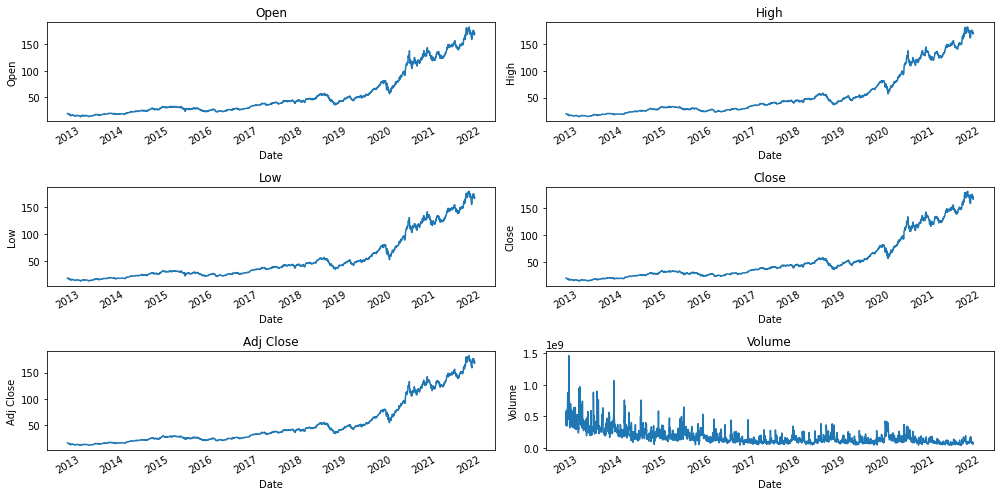

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.011290443155084609
0.011290443155084609
250 50 5
Epoch 1/10
112/112 [==============================] - 51s 382ms/step - loss: 6.5643e-04 - val_loss: 7.3853e-04
Epoch 2/10
112/112 [==============================] - 31s 280ms/step - loss: 8.3979e-05 - val_loss: 0.0020
Epoch 3/10
112/112 [==============================] - 32s 289ms/step - loss: 6.5743e-05 - val_loss: 9.8910e-04
Epoch 4/10
112/112 [==============================] - 32s 290ms/step - loss: 6.4795e-05 - val_loss: 0.0012
Epoch 5/10
112/112 [==============================] - 31s 280ms/step - loss: 6.0801e-05 - val_loss: 7.4891e-04
Epoch 6/10
112/112 [==============================] - 31s 281ms/step - loss: 6.7321e-05 - val_loss: 5.5771e-04
Epoch 7/10
112/112 [==============================] - 32s 288ms/step - loss: 4.9482e-05 - val_loss: 5.4820e-04
Epoch 8/10
112/112 [==============================] - 32s 282ms/step - l

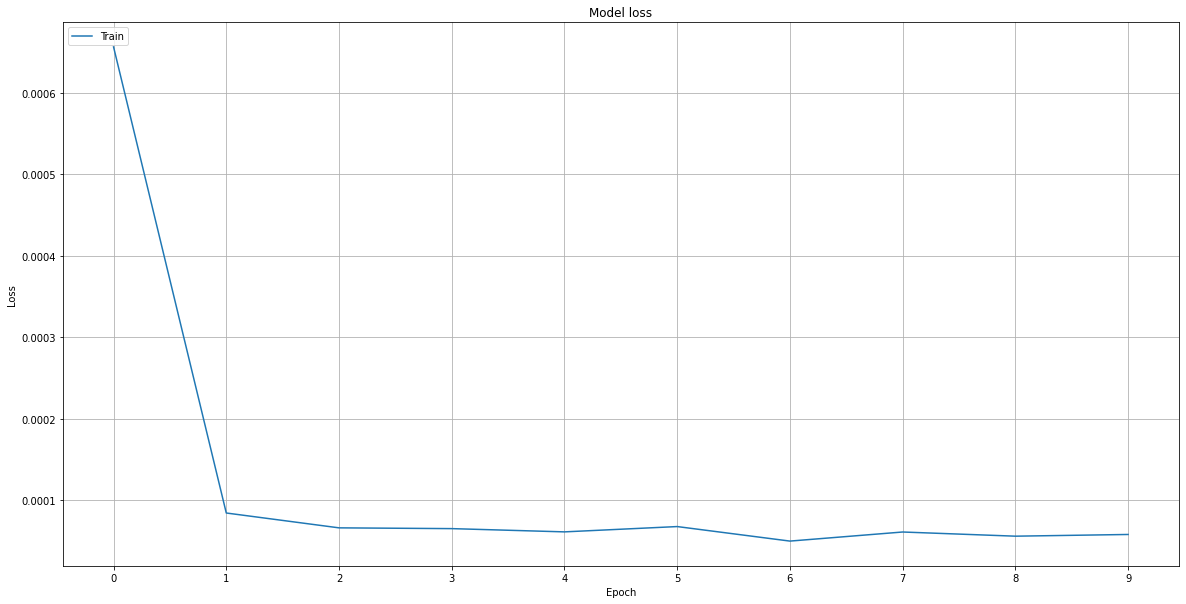

Median Absolute Error (MAE): 2.61
Mean Absolute Percentage Error (MAPE): 2.02 %
Median Absolute Percentage Error (MDAPE): 1.5 %


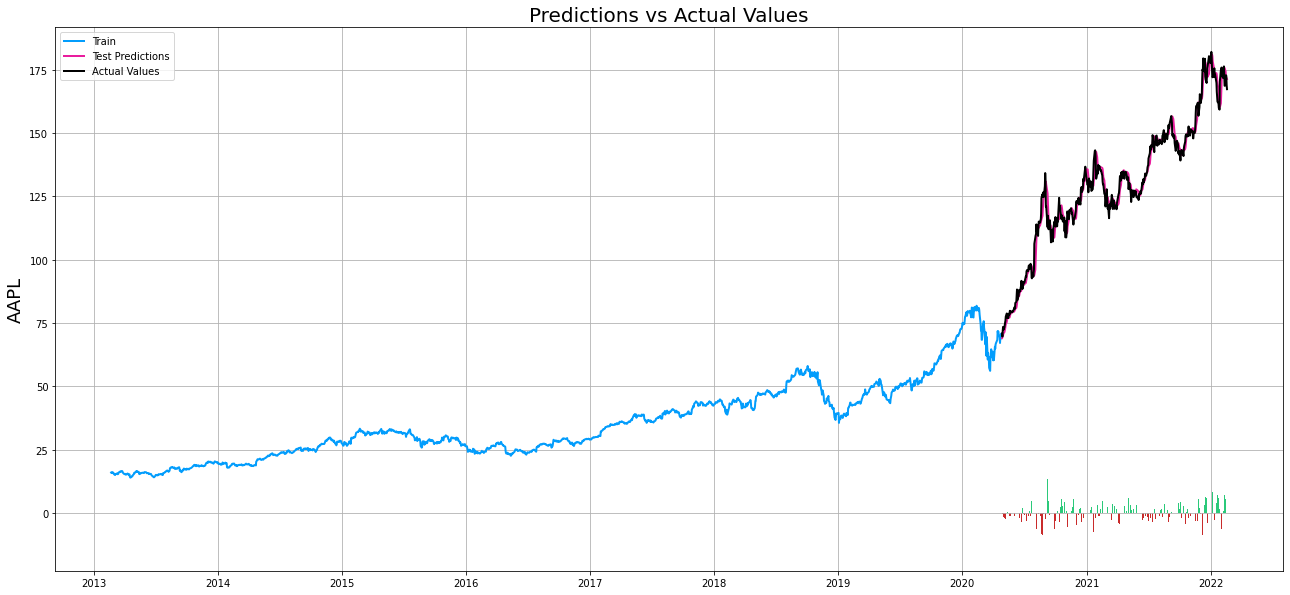

The close price for AAPL at 2022-02-20 was 167.3
The predicted close price is 170.49000549316406 (+1.87%)
[*********************100%***********************]  1 of 1 completed


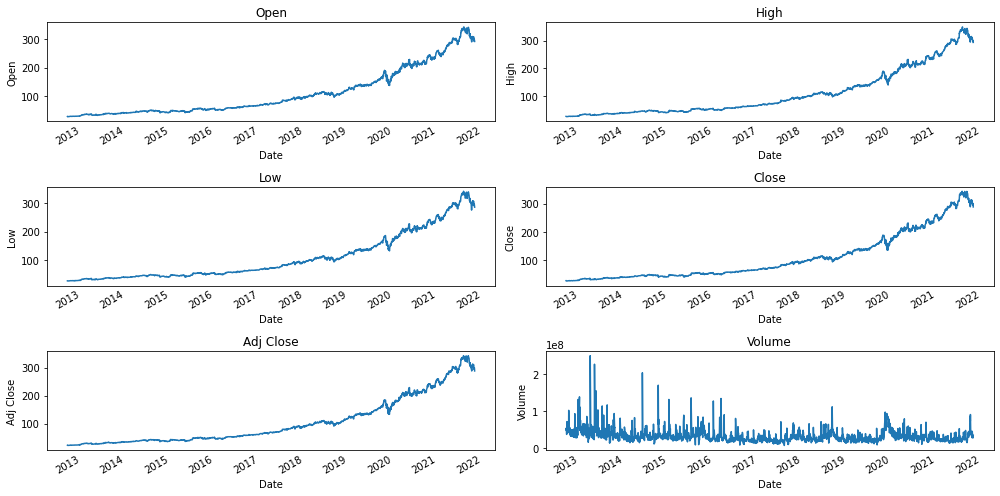

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.004989742300894898
0.004989742300894898
250 50 5
Epoch 1/10
112/112 [==============================] - 37s 291ms/step - loss: 0.0012 - val_loss: 6.0802e-04
Epoch 2/10
112/112 [==============================] - 32s 282ms/step - loss: 7.3468e-05 - val_loss: 5.1744e-04
Epoch 3/10
112/112 [==============================] - 33s 293ms/step - loss: 7.8151e-05 - val_loss: 7.1577e-04
Epoch 4/10
112/112 [==============================] - 32s 287ms/step - loss: 7.4827e-05 - val_loss: 4.6786e-04
Epoch 5/10
112/112 [==============================] - 32s 290ms/step - loss: 5.9408e-05 - val_loss: 4.6698e-04
Epoch 6/10
112/112 [==============================] - 33s 291ms/step - loss: 8.1233e-05 - val_loss: 0.0015
Epoch 7/10
112/112 [==============================] - 32s 289ms/step - loss: 7.8069e-05 - val_loss: 0.0015
Epoch 8/10
112/112 [==============================] - 32s 289ms/step - loss:

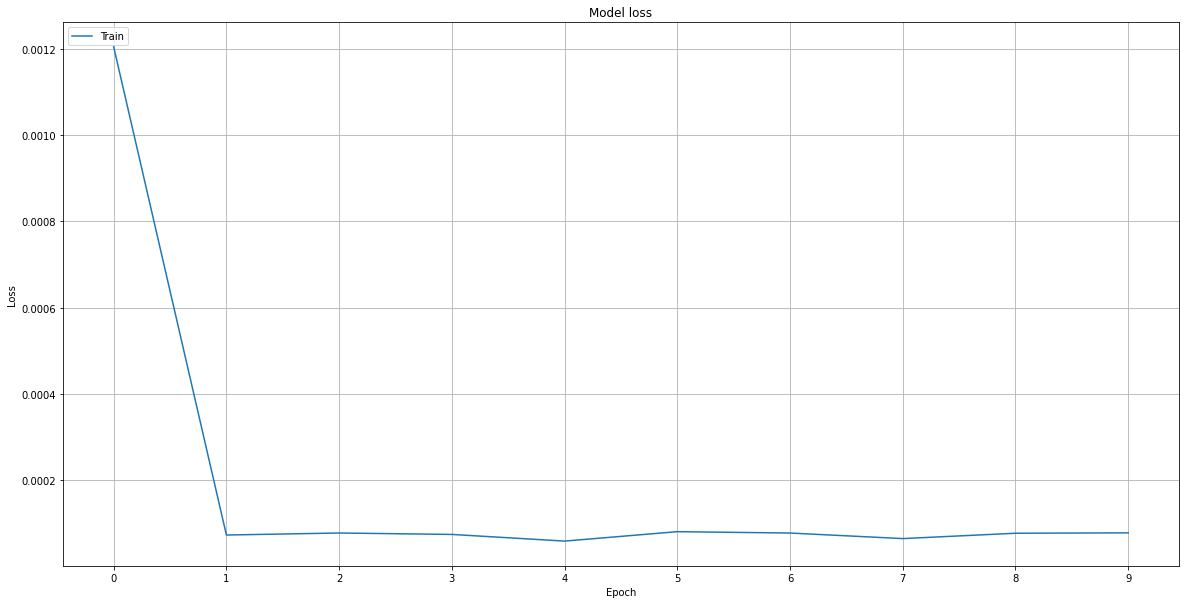

Median Absolute Error (MAE): 6.72
Mean Absolute Percentage Error (MAPE): 2.69 %
Median Absolute Percentage Error (MDAPE): 2.38 %


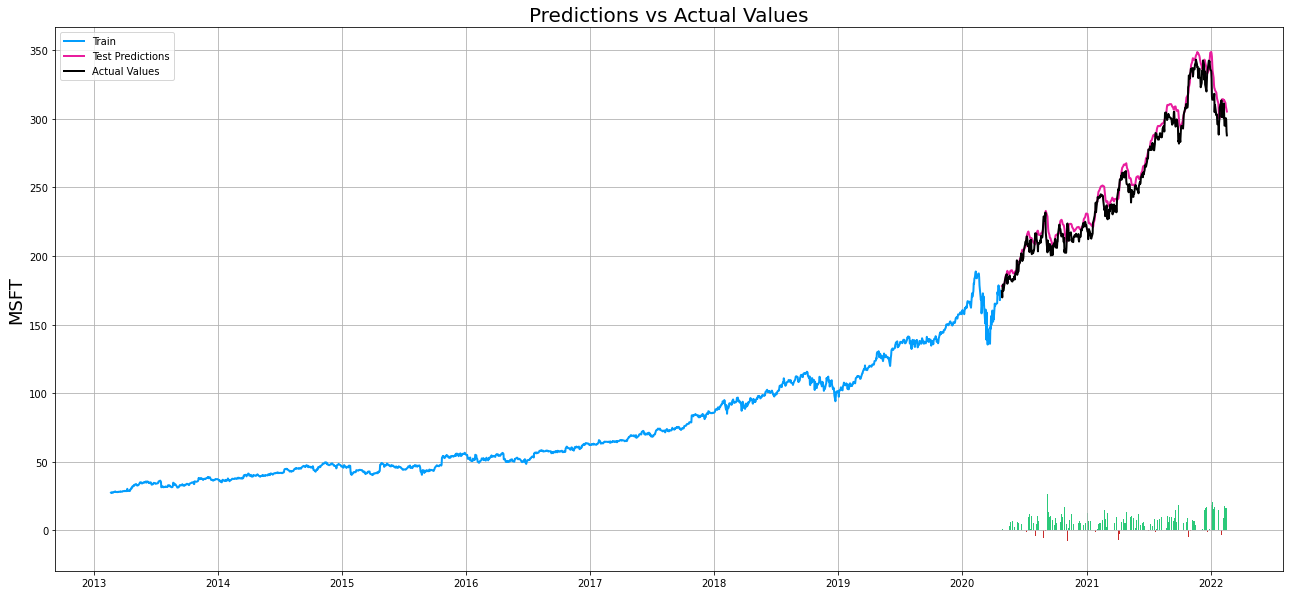

The close price for MSFT at 2022-02-20 was 287.93
The predicted close price is 303.07000732421875 (+5.0%)
[*********************100%***********************]  1 of 1 completed


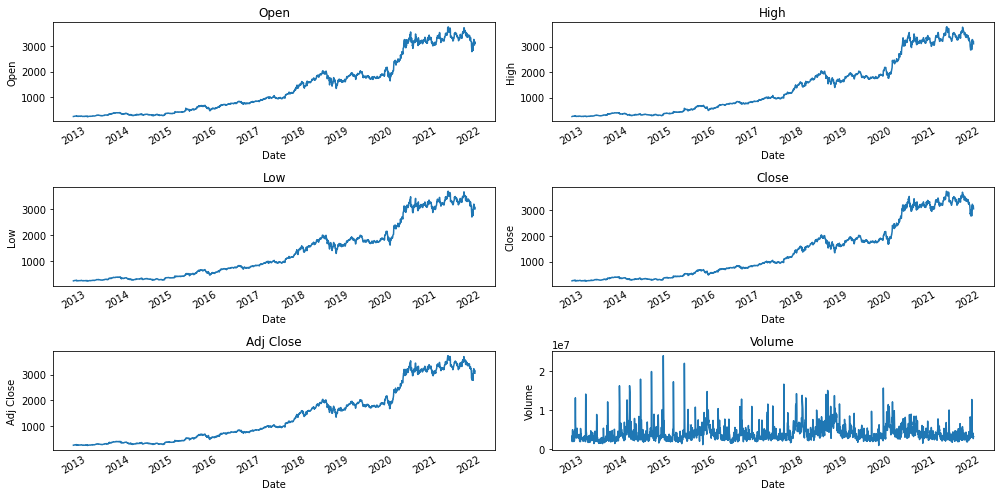

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.0039016105750851737
0.0039016105750851737
250 50 5
Epoch 1/10
112/112 [==============================] - 37s 293ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 2/10
112/112 [==============================] - 32s 285ms/step - loss: 1.8617e-04 - val_loss: 0.0015
Epoch 3/10
112/112 [==============================] - 32s 288ms/step - loss: 2.3213e-04 - val_loss: 9.3890e-04
Epoch 4/10
112/112 [==============================] - 32s 287ms/step - loss: 1.4201e-04 - val_loss: 0.0011
Epoch 5/10
112/112 [==============================] - 32s 284ms/step - loss: 1.3736e-04 - val_loss: 0.0011
Epoch 6/10
112/112 [==============================] - 32s 286ms/step - loss: 1.6335e-04 - val_loss: 9.6958e-04
Epoch 7/10
112/112 [==============================] - 32s 289ms/step - loss: 1.7122e-04 - val_loss: 9.2069e-04
Epoch 8/10
112/112 [==============================] - 32s 282ms/step - loss: 1.215

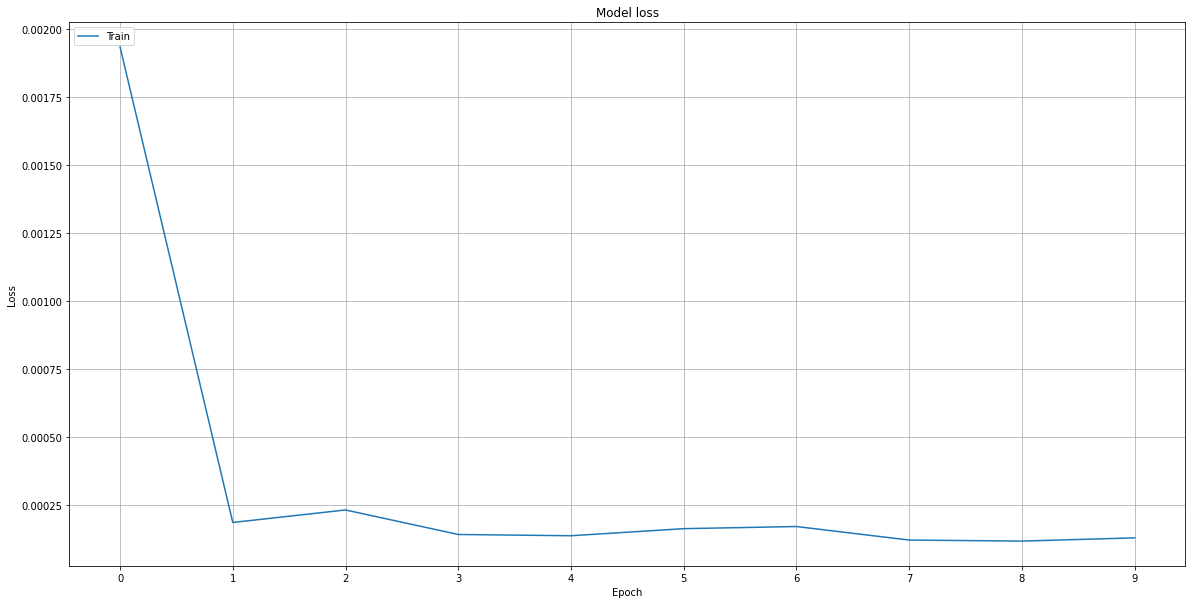

Median Absolute Error (MAE): 67.58
Mean Absolute Percentage Error (MAPE): 2.11 %
Median Absolute Percentage Error (MDAPE): 1.67 %


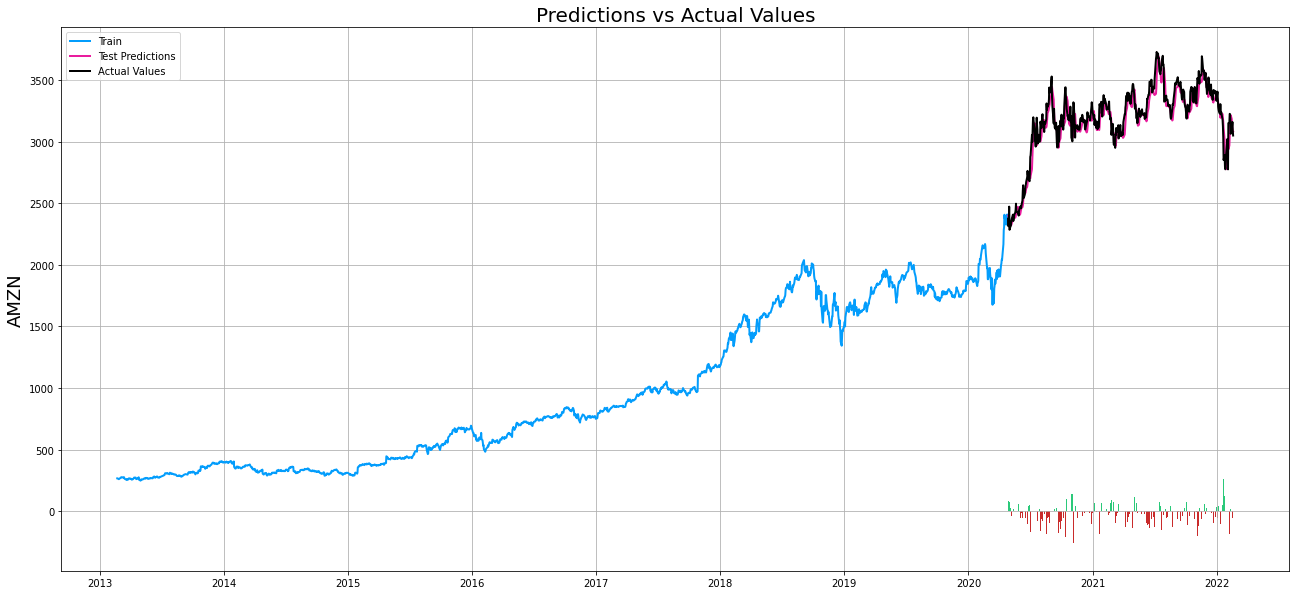

The close price for AMZN at 2022-02-20 was 3052.03
The predicted close price is 3066.27001953125 (+0.46%)
[*********************100%***********************]  1 of 1 completed


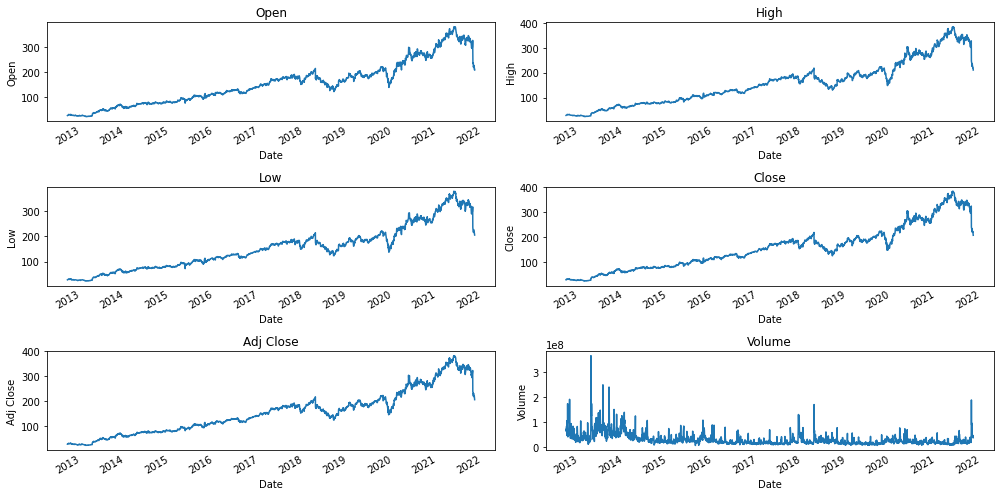

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.010437541951862708
0.010437541951862708
250 50 5
Epoch 1/10
112/112 [==============================] - 37s 296ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 2/10
112/112 [==============================] - 32s 282ms/step - loss: 1.9273e-04 - val_loss: 0.0018
Epoch 3/10
112/112 [==============================] - 32s 286ms/step - loss: 1.9384e-04 - val_loss: 0.0013
Epoch 4/10
112/112 [==============================] - 32s 286ms/step - loss: 1.7795e-04 - val_loss: 0.0015
Epoch 5/10
112/112 [==============================] - 32s 284ms/step - loss: 1.4671e-04 - val_loss: 8.8385e-04
Epoch 6/10
112/112 [==============================] - 32s 286ms/step - loss: 1.5415e-04 - val_loss: 0.0011
Epoch 7/10
112/112 [==============================] - 32s 284ms/step - loss: 1.4343e-04 - val_loss: 7.9783e-04
Epoch 8/10
112/112 [==============================] - 32s 284ms/step - loss: 1.4406e-04 

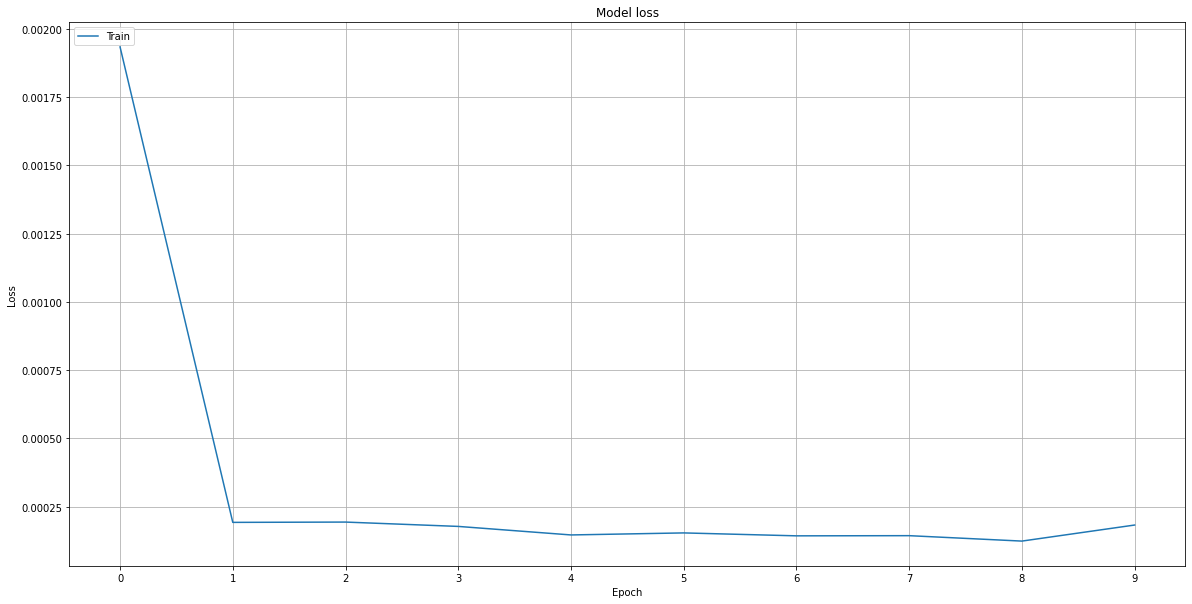

Median Absolute Error (MAE): 7.61
Mean Absolute Percentage Error (MAPE): 2.63 %
Median Absolute Percentage Error (MDAPE): 2.07 %


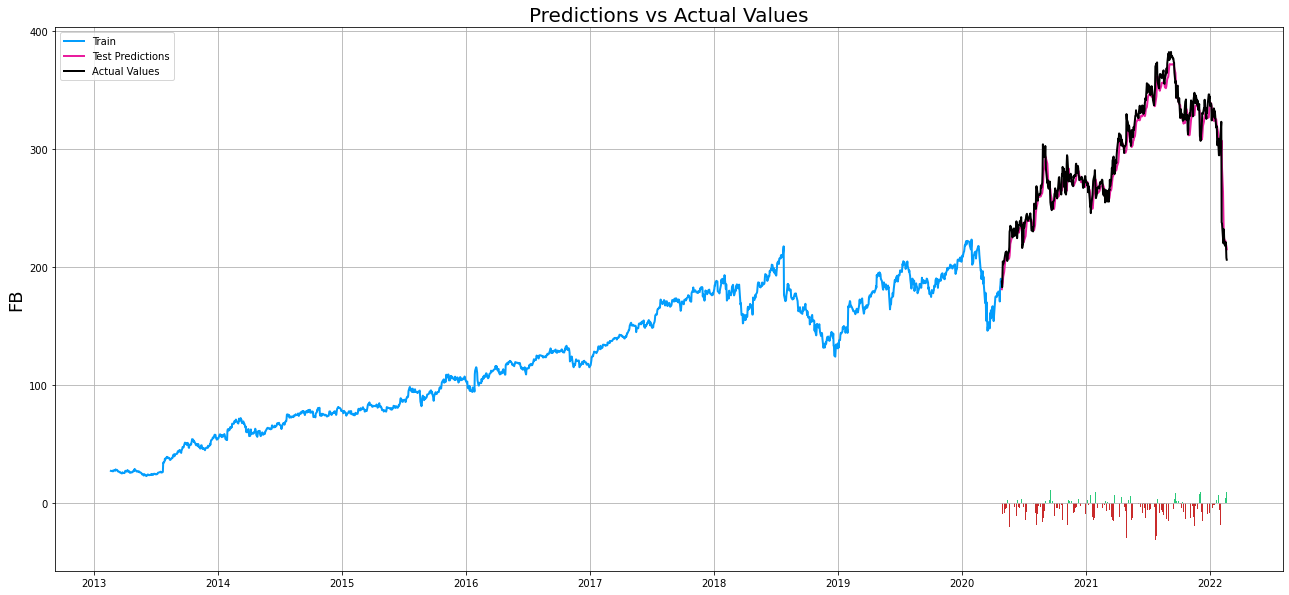

The close price for FB at 2022-02-20 was 206.16
The predicted close price is 212.0500030517578 (+2.78%)
[*********************100%***********************]  1 of 1 completed


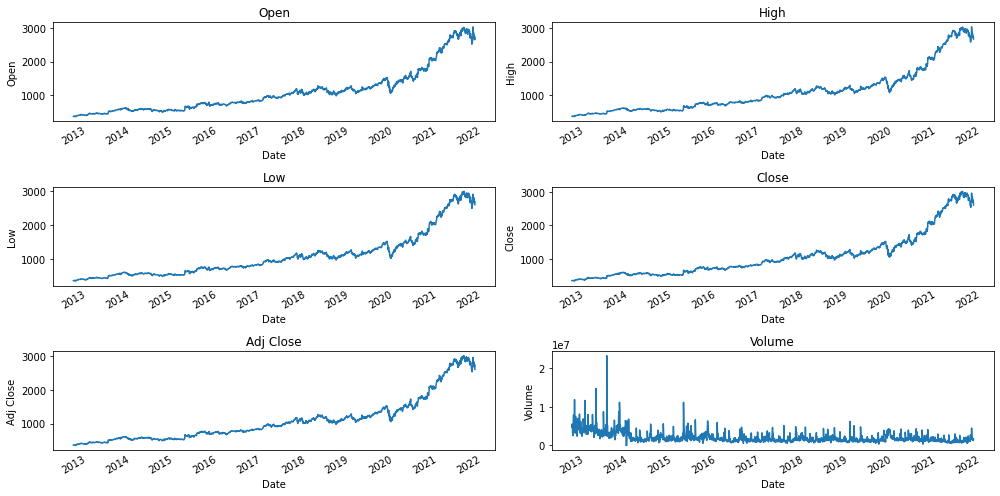

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.020835497191967783
0.020835497191967783
250 50 5
Epoch 1/10
112/112 [==============================] - 37s 295ms/step - loss: 8.6524e-04 - val_loss: 0.0048
Epoch 2/10
112/112 [==============================] - 32s 287ms/step - loss: 1.2674e-04 - val_loss: 0.0017
Epoch 3/10
112/112 [==============================] - 32s 286ms/step - loss: 1.0408e-04 - val_loss: 0.0029
Epoch 4/10
112/112 [==============================] - 32s 289ms/step - loss: 9.8559e-05 - val_loss: 8.3588e-04
Epoch 5/10
112/112 [==============================] - 32s 288ms/step - loss: 8.2404e-05 - val_loss: 6.2588e-04
Epoch 6/10
112/112 [==============================] - 33s 291ms/step - loss: 9.1380e-05 - val_loss: 6.8109e-04
Epoch 7/10
112/112 [==============================] - 33s 292ms/step - loss: 8.0584e-05 - val_loss: 5.5226e-04
Epoch 8/10
112/112 [==============================] - 32s 288ms/step - loss:

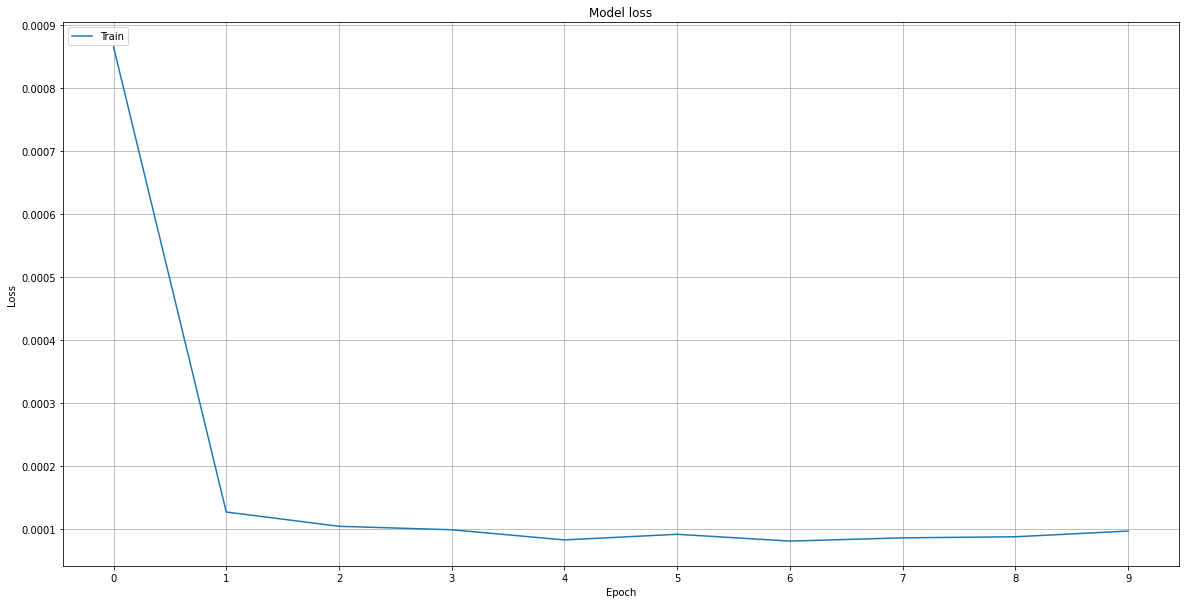

Median Absolute Error (MAE): 37.38
Mean Absolute Percentage Error (MAPE): 1.73 %
Median Absolute Percentage Error (MDAPE): 1.38 %


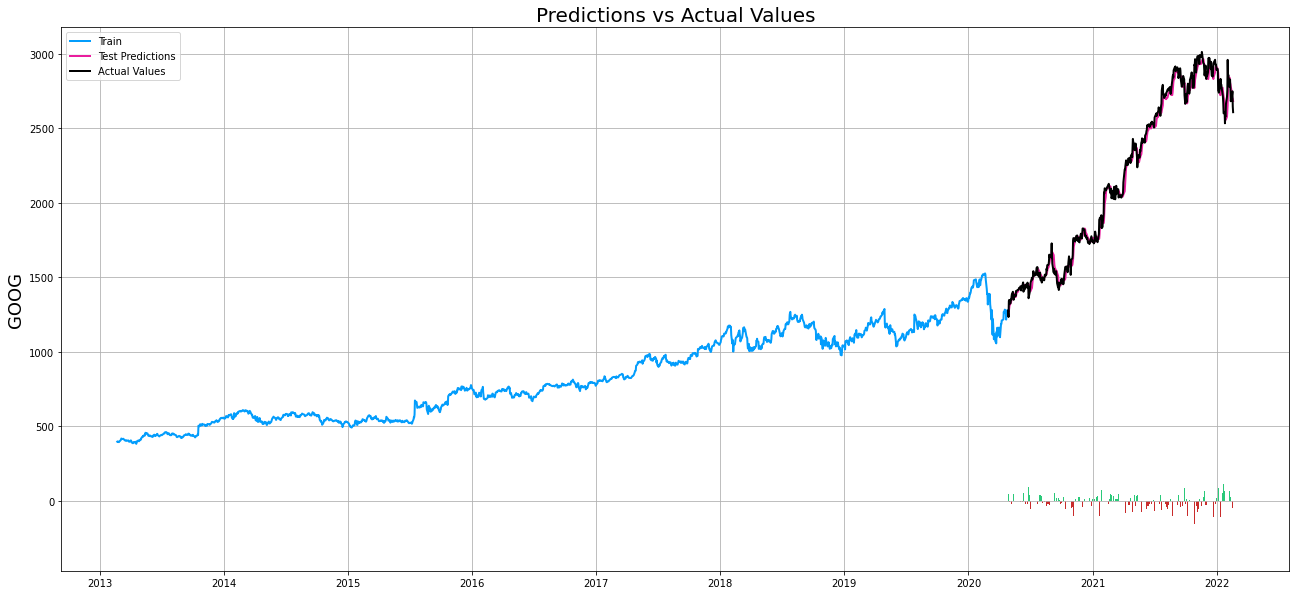

The close price for GOOG at 2022-02-20 was 2609.35
The predicted close price is 2657.010009765625 (+1.79%)
[*********************100%***********************]  1 of 1 completed


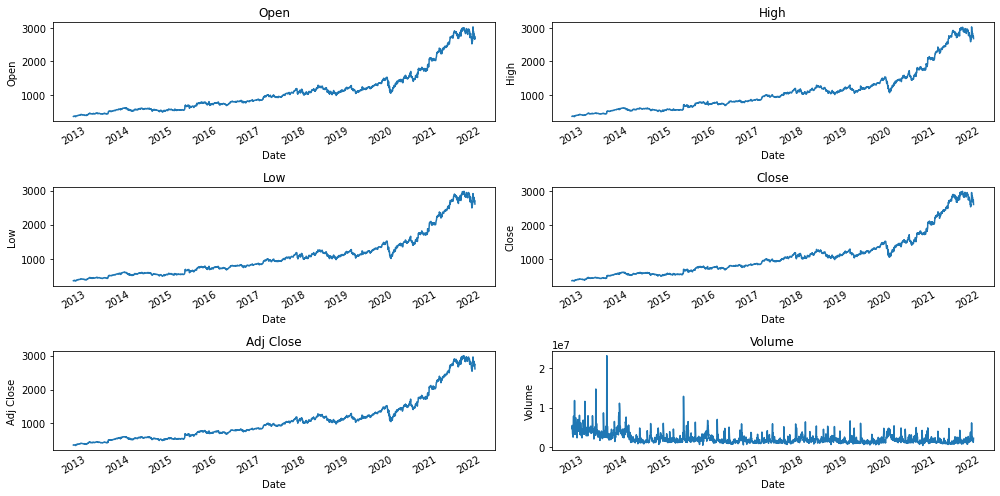

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.02108549555397607
0.02108549555397607
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 299ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/10
112/112 [==============================] - 32s 288ms/step - loss: 1.1504e-04 - val_loss: 8.6192e-04
Epoch 3/10
112/112 [==============================] - 32s 289ms/step - loss: 1.0817e-04 - val_loss: 0.0015
Epoch 4/10
112/112 [==============================] - 33s 292ms/step - loss: 9.4248e-05 - val_loss: 6.7284e-04
Epoch 5/10
112/112 [==============================] - 32s 290ms/step - loss: 8.9733e-05 - val_loss: 8.3767e-04
Epoch 6/10
112/112 [==============================] - 33s 298ms/step - loss: 1.0861e-04 - val_loss: 0.0019
Epoch 7/10
112/112 [==============================] - 33s 298ms/step - loss: 8.1503e-05 - val_loss: 8.3010e-04
Epoch 8/10
112/112 [==============================] - 34s 300ms/step - loss: 7.309

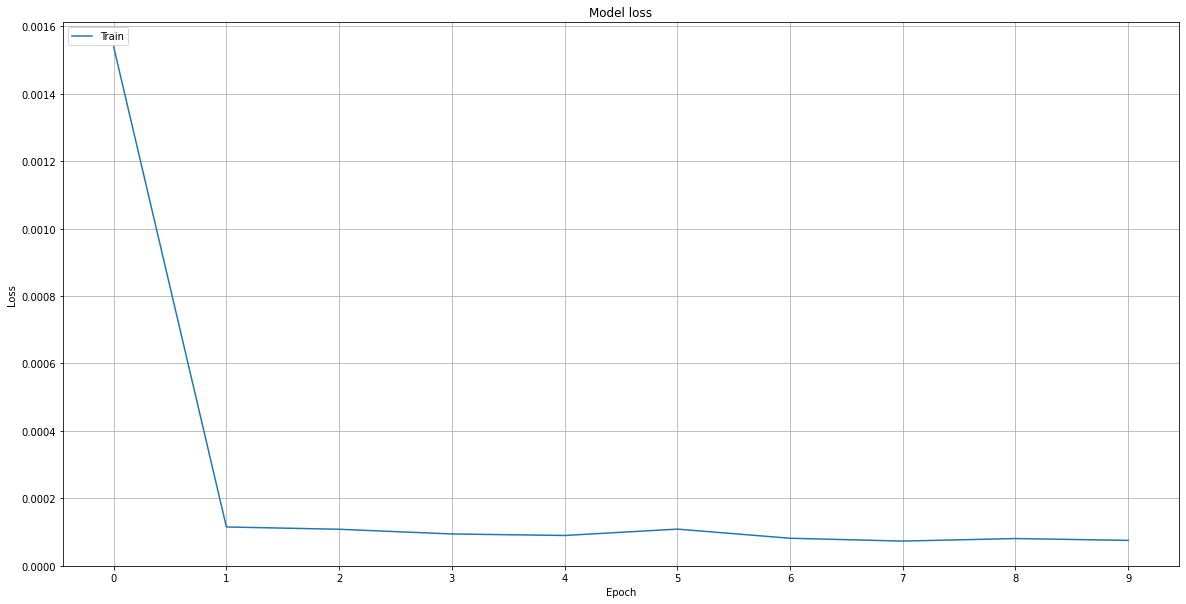

Median Absolute Error (MAE): 80.56
Mean Absolute Percentage Error (MAPE): 3.55 %
Median Absolute Percentage Error (MDAPE): 3.5 %


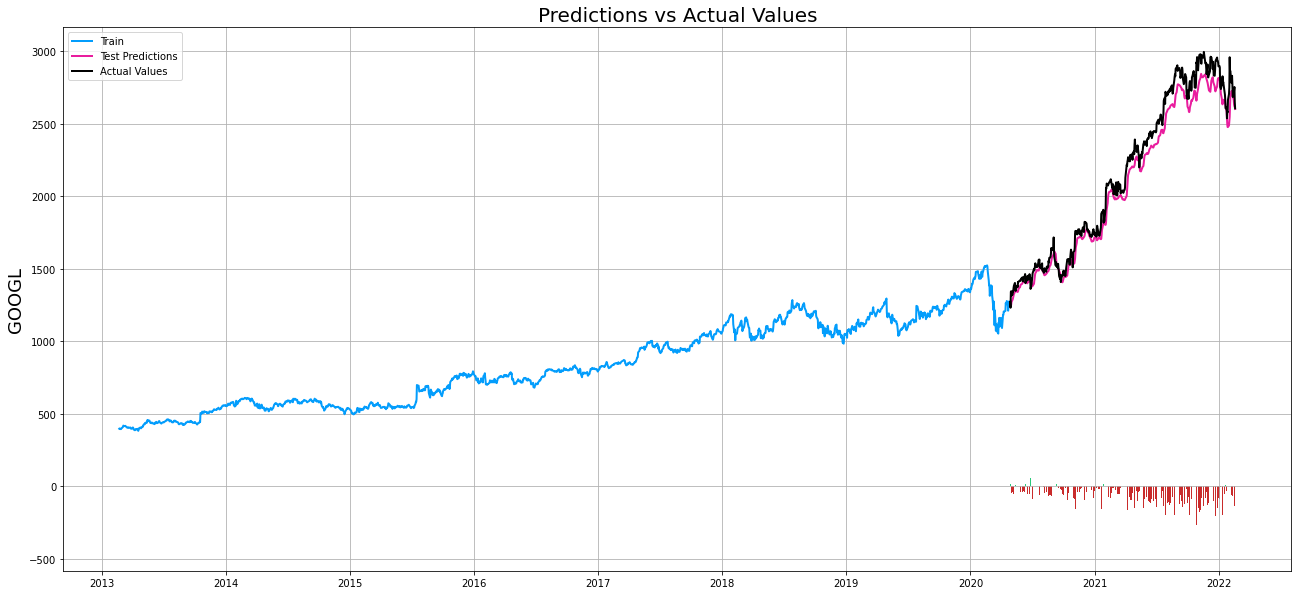

The close price for GOOGL at 2022-02-20 was 2608.06
The predicted close price is 2575.72998046875 (-1.26%)
[*********************100%***********************]  1 of 1 completed


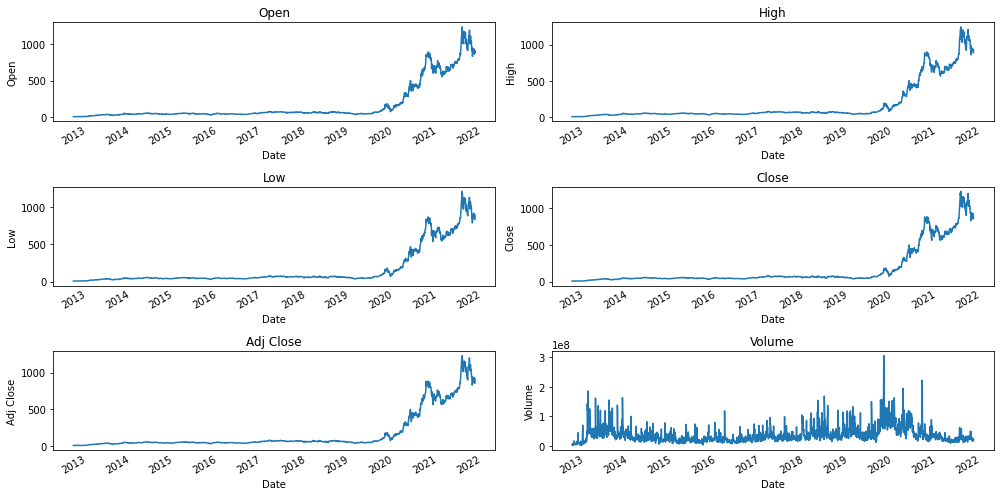

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.00038910275543842503
0.00038910275543842503
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 302ms/step - loss: 2.2687e-04 - val_loss: 0.0044
Epoch 2/10
112/112 [==============================] - 32s 288ms/step - loss: 2.0016e-05 - val_loss: 0.0039
Epoch 3/10
112/112 [==============================] - 33s 291ms/step - loss: 2.0811e-05 - val_loss: 0.0034
Epoch 4/10
112/112 [==============================] - 33s 297ms/step - loss: 1.7361e-05 - val_loss: 0.0014
Epoch 5/10
112/112 [==============================] - 33s 298ms/step - loss: 1.3147e-05 - val_loss: 0.0025
Epoch 6/10
112/112 [==============================] - 33s 295ms/step - loss: 1.5848e-05 - val_loss: 0.0012
Epoch 7/10
112/112 [==============================] - 32s 289ms/step - loss: 1.3908e-05 - val_loss: 0.0026
Epoch 8/10
112/112 [==============================] - 33s 290ms/step - loss: 1.1843e-05 

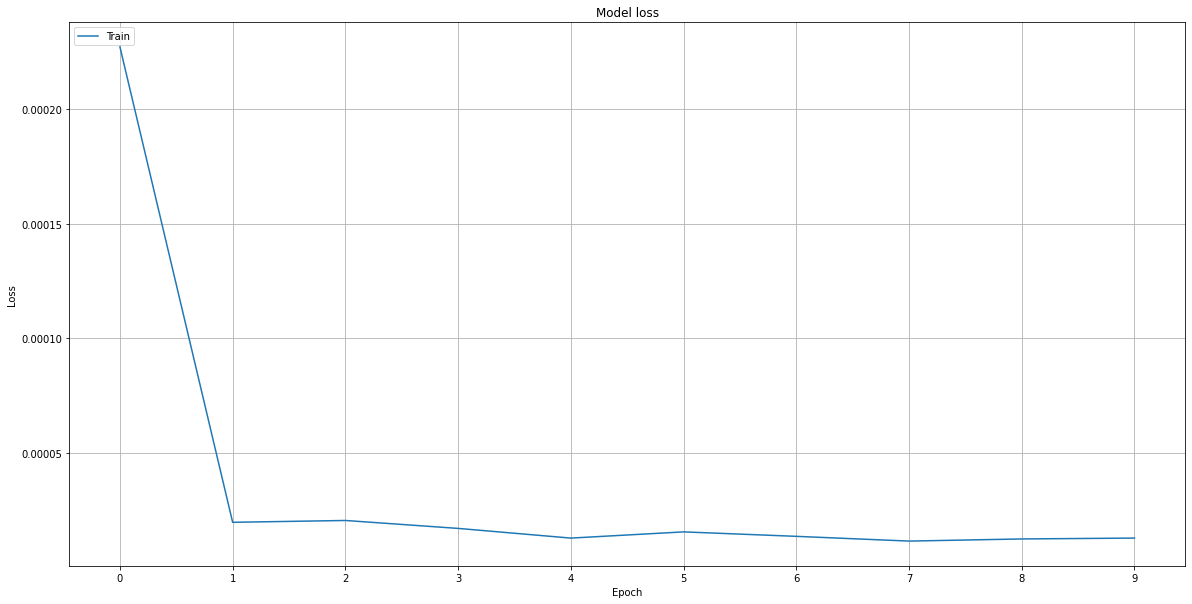

Median Absolute Error (MAE): 48.4
Mean Absolute Percentage Error (MAPE): 6.92 %
Median Absolute Percentage Error (MDAPE): 6.54 %


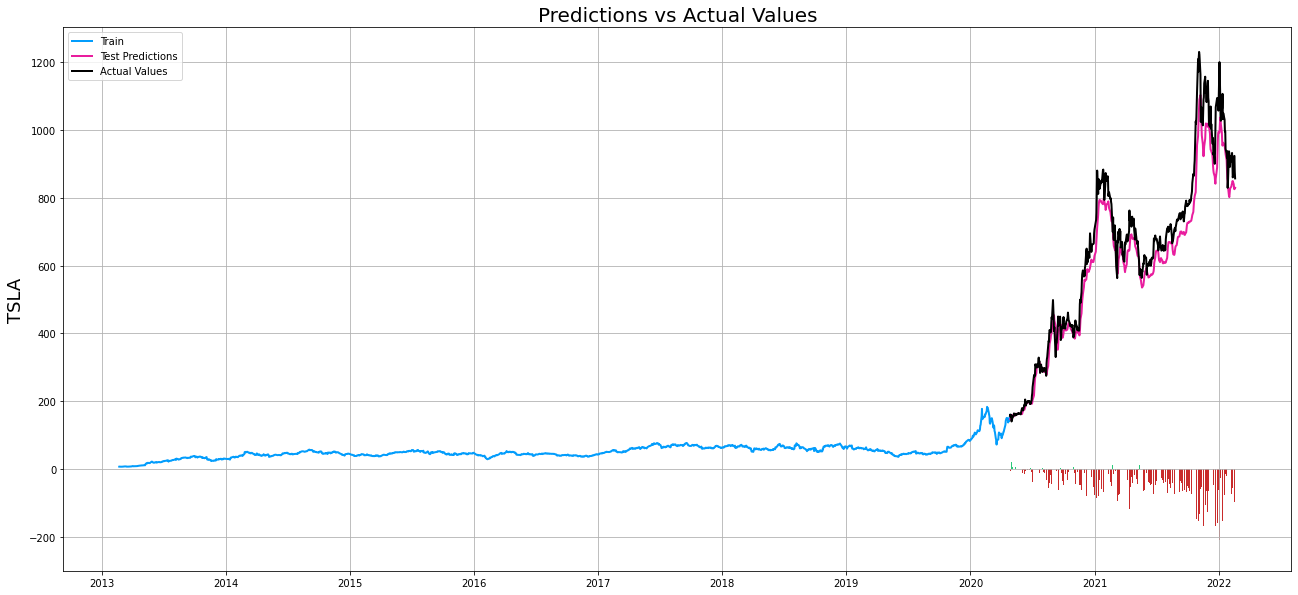

The close price for TSLA at 2022-02-20 was 856.98
The predicted close price is 819.5800170898438 (-4.56%)
[*********************100%***********************]  1 of 1 completed


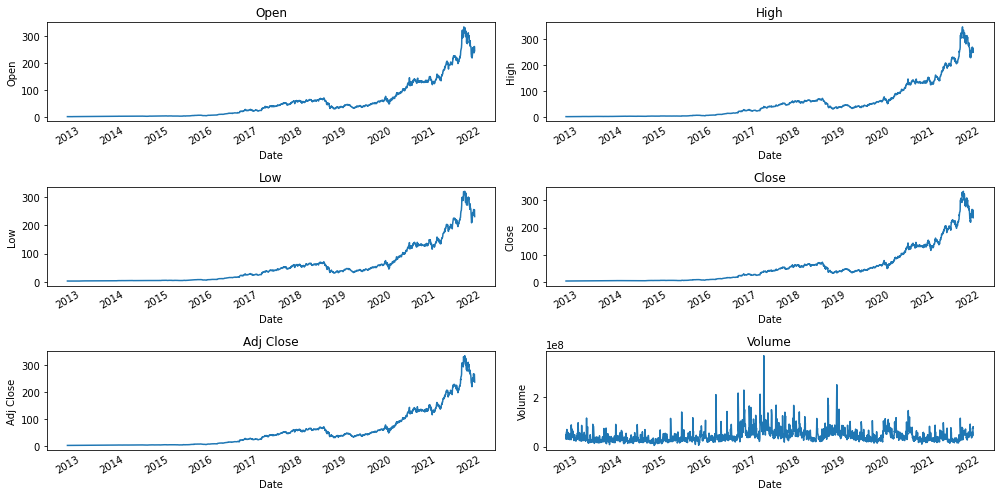

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.0004988441804392625
0.0004988441804392625
250 50 5
Epoch 1/10
112/112 [==============================] - 37s 298ms/step - loss: 3.2452e-04 - val_loss: 0.0017
Epoch 2/10
112/112 [==============================] - 33s 291ms/step - loss: 3.6164e-05 - val_loss: 9.8019e-04
Epoch 3/10
112/112 [==============================] - 33s 292ms/step - loss: 3.8243e-05 - val_loss: 0.0023
Epoch 4/10
112/112 [==============================] - 33s 291ms/step - loss: 4.7692e-05 - val_loss: 8.2086e-04
Epoch 5/10
112/112 [==============================] - 33s 292ms/step - loss: 3.6343e-05 - val_loss: 0.0021
Epoch 6/10
112/112 [==============================] - 33s 291ms/step - loss: 3.0464e-05 - val_loss: 7.7863e-04
Epoch 7/10
112/112 [==============================] - 33s 293ms/step - loss: 2.8013e-05 - val_loss: 0.0014
Epoch 8/10
112/112 [==============================] - 33s 291ms/step - loss: 2

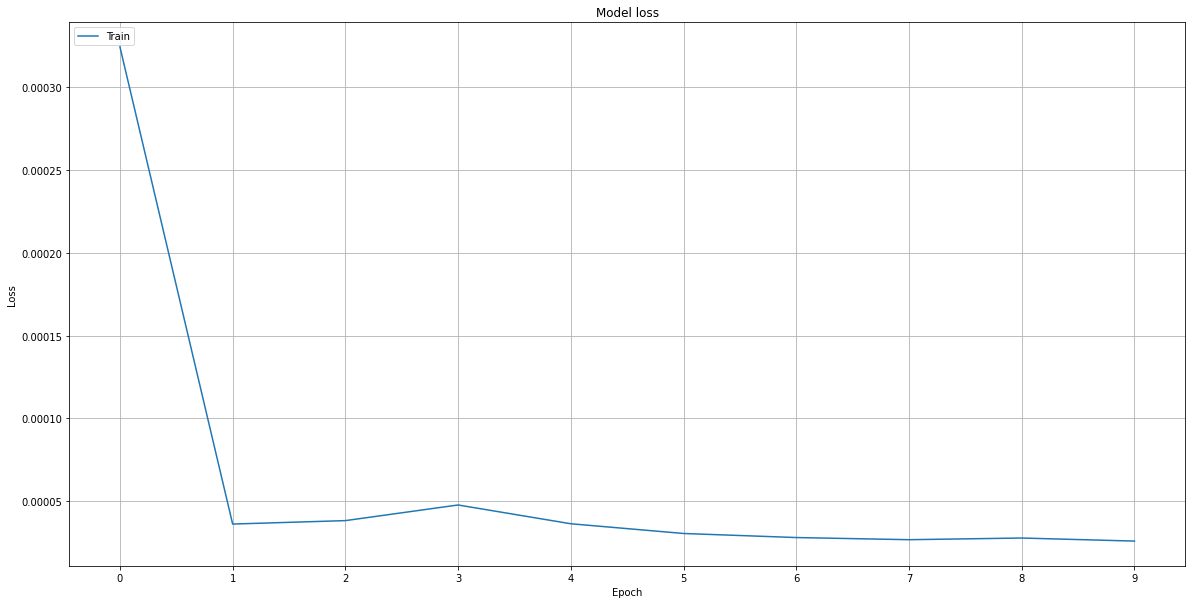

Median Absolute Error (MAE): 5.51
Mean Absolute Percentage Error (MAPE): 3.01 %
Median Absolute Percentage Error (MDAPE): 2.5 %


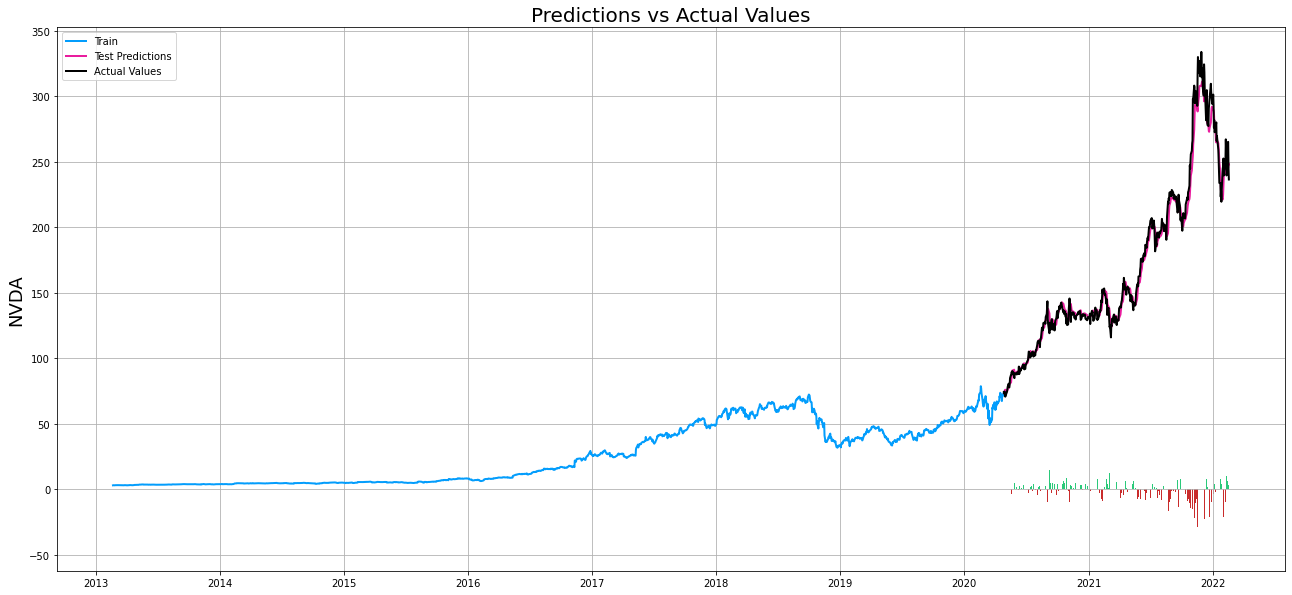

The close price for NVDA at 2022-02-20 was 236.42
The predicted close price is 243.61000061035156 (+2.95%)
[*********************100%***********************]  1 of 1 completed


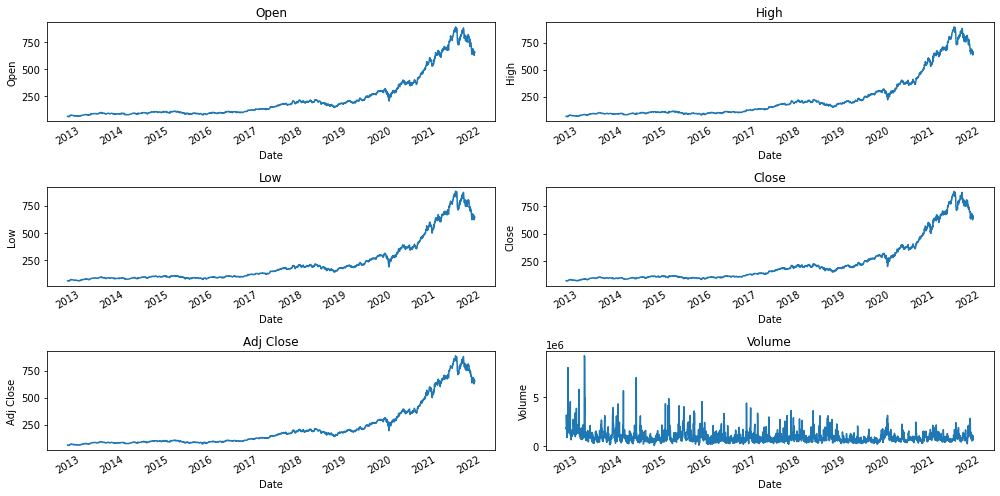

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.009367622052442917
0.009367622052442917
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 303ms/step - loss: 4.9816e-04 - val_loss: 7.9081e-04
Epoch 2/10
112/112 [==============================] - 33s 297ms/step - loss: 6.1944e-05 - val_loss: 8.8175e-04
Epoch 3/10
112/112 [==============================] - 33s 296ms/step - loss: 6.1397e-05 - val_loss: 7.2188e-04
Epoch 4/10
112/112 [==============================] - 33s 295ms/step - loss: 5.9037e-05 - val_loss: 8.9799e-04
Epoch 5/10
112/112 [==============================] - 33s 292ms/step - loss: 5.0888e-05 - val_loss: 6.8111e-04
Epoch 6/10
112/112 [==============================] - 33s 298ms/step - loss: 4.8930e-05 - val_loss: 7.0813e-04
Epoch 7/10
112/112 [==============================] - 33s 292ms/step - loss: 4.4085e-05 - val_loss: 0.0013
Epoch 8/10
112/112 [==============================] - 33s 295ms/step

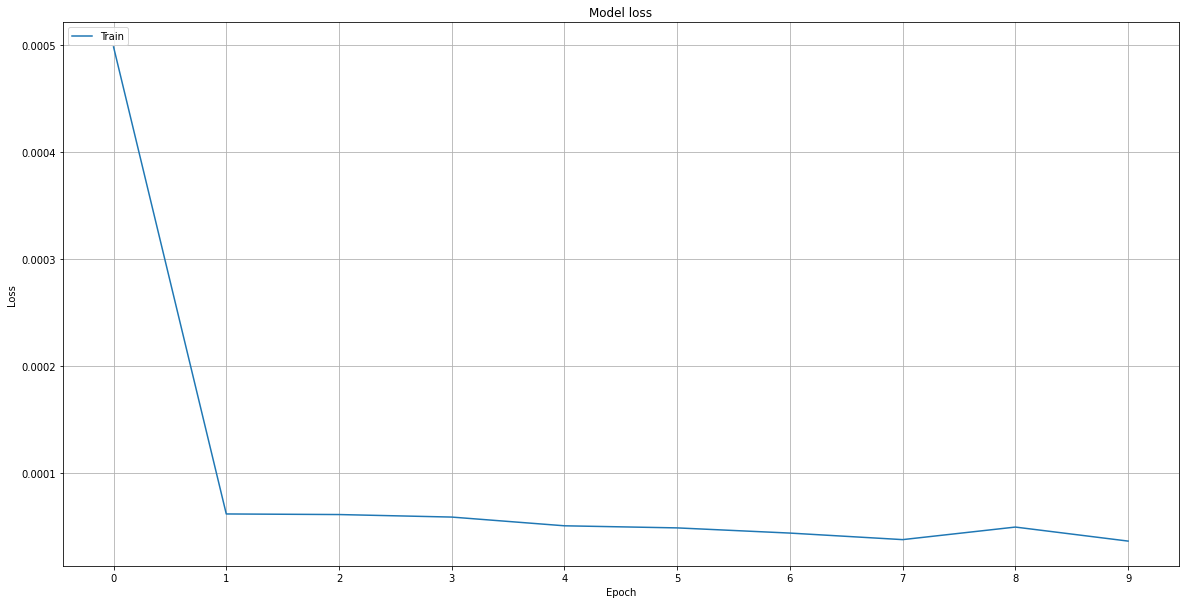

Median Absolute Error (MAE): 23.63
Mean Absolute Percentage Error (MAPE): 3.89 %
Median Absolute Percentage Error (MDAPE): 3.88 %


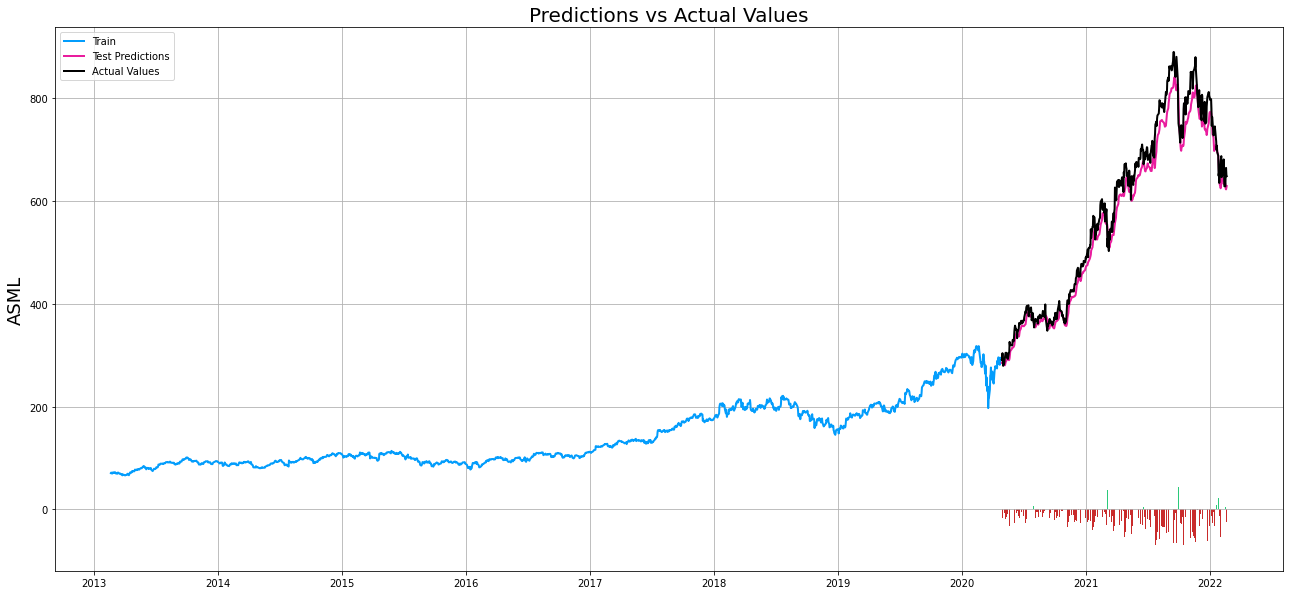

The close price for ASML at 2022-02-20 was 647.83
The predicted close price is 629.4299926757812 (-2.92%)
[*********************100%***********************]  1 of 1 completed


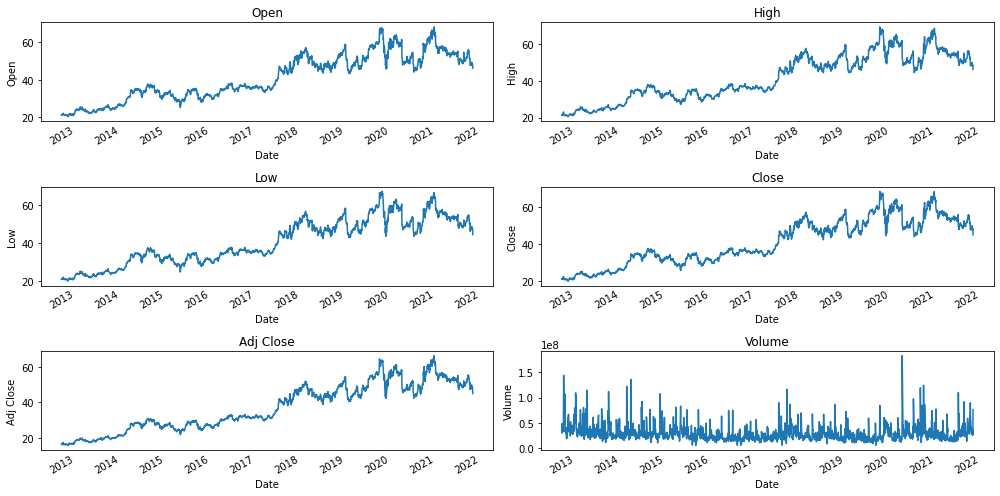

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.023839128907899798
0.023839128907899798
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 300ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 2/10
112/112 [==============================] - 33s 291ms/step - loss: 9.6874e-04 - val_loss: 0.0015
Epoch 3/10
112/112 [==============================] - 33s 292ms/step - loss: 7.6829e-04 - val_loss: 0.0015
Epoch 4/10
112/112 [==============================] - 33s 293ms/step - loss: 6.2967e-04 - val_loss: 0.0012
Epoch 5/10
112/112 [==============================] - 33s 292ms/step - loss: 5.6261e-04 - val_loss: 0.0012
Epoch 6/10
112/112 [==============================] - 33s 298ms/step - loss: 5.3851e-04 - val_loss: 0.0011
Epoch 7/10
112/112 [==============================] - 33s 294ms/step - loss: 5.5944e-04 - val_loss: 0.0011
Epoch 8/10
112/112 [==============================] - 33s 291ms/step - loss: 4.5997e-04 - val_lo

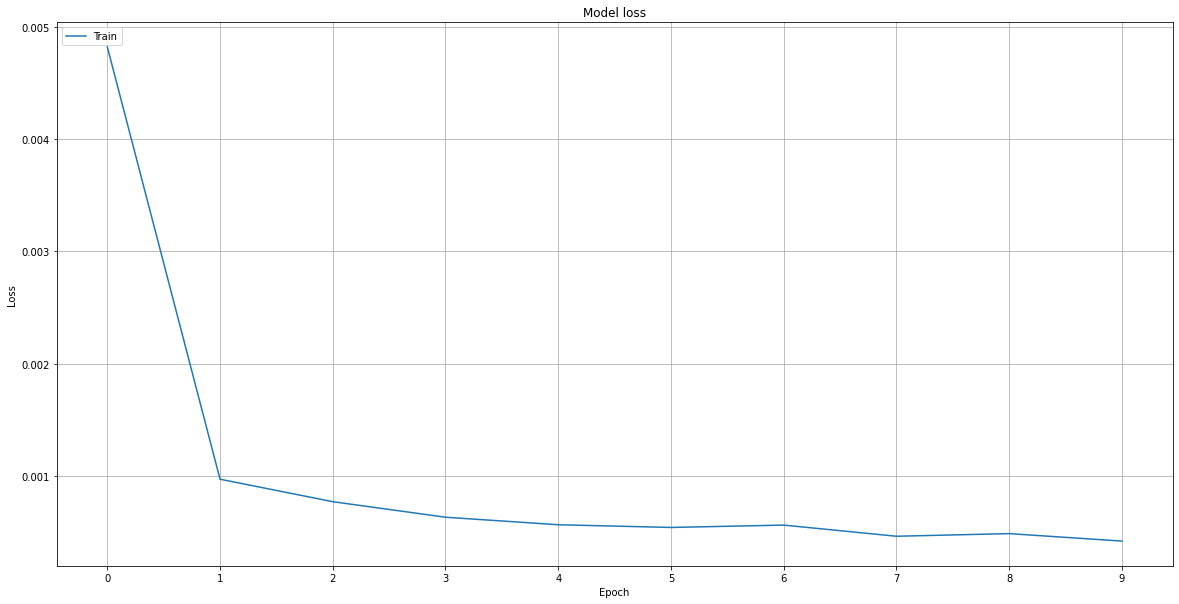

Median Absolute Error (MAE): 1.19
Mean Absolute Percentage Error (MAPE): 2.22 %
Median Absolute Percentage Error (MDAPE): 1.69 %


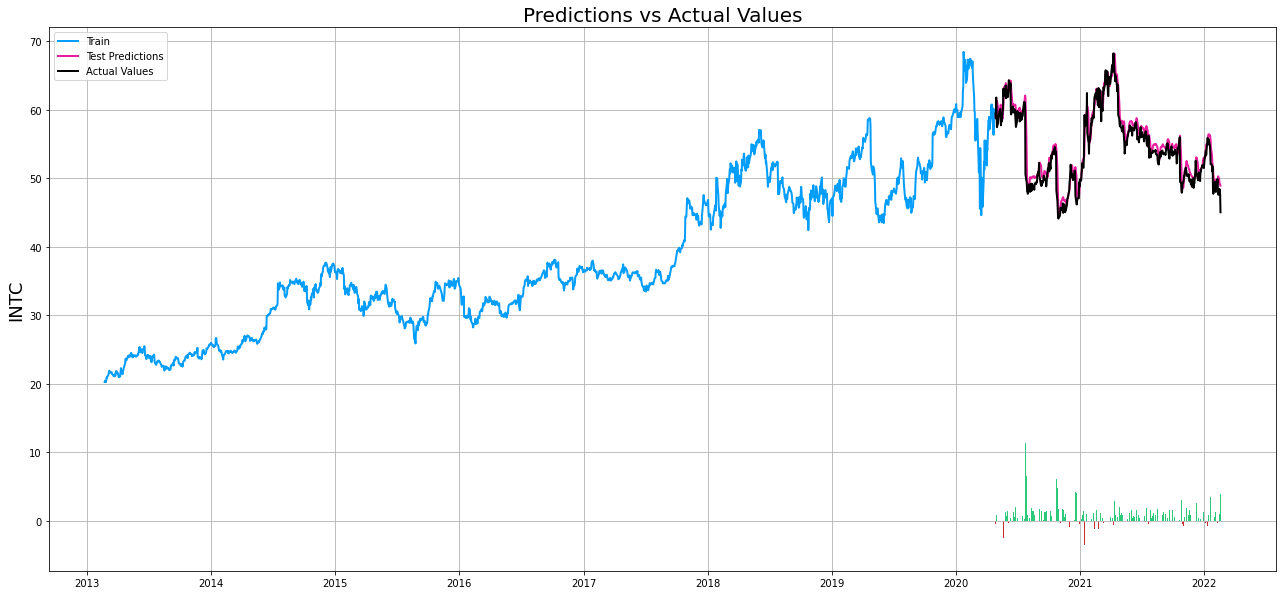

The close price for INTC at 2022-02-20 was 45.04
The predicted close price is 47.650001525878906 (+5.48%)
[*********************100%***********************]  1 of 1 completed


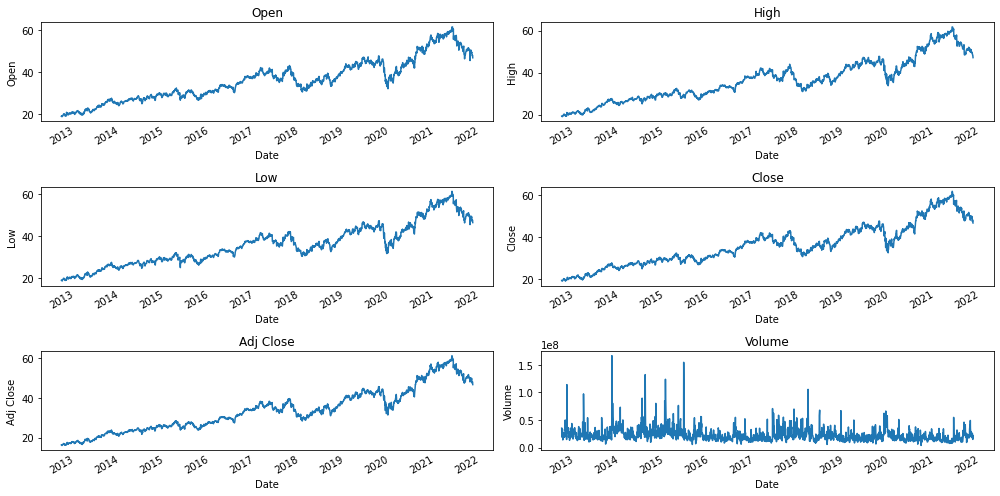

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.03282707486780245
0.03282707486780245
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 302ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 2/10
112/112 [==============================] - 33s 295ms/step - loss: 3.7273e-04 - val_loss: 8.0746e-04
Epoch 3/10
112/112 [==============================] - 33s 294ms/step - loss: 3.8633e-04 - val_loss: 0.0011
Epoch 4/10
112/112 [==============================] - 33s 295ms/step - loss: 3.6552e-04 - val_loss: 9.2528e-04
Epoch 5/10
112/112 [==============================] - 33s 293ms/step - loss: 3.9500e-04 - val_loss: 0.0015
Epoch 6/10
112/112 [==============================] - 33s 292ms/step - loss: 3.6241e-04 - val_loss: 6.9360e-04
Epoch 7/10
112/112 [==============================] - 33s 294ms/step - loss: 3.1191e-04 - val_loss: 6.0243e-04
Epoch 8/10
112/112 [==============================] - 33s 293ms/step - loss: 2.993

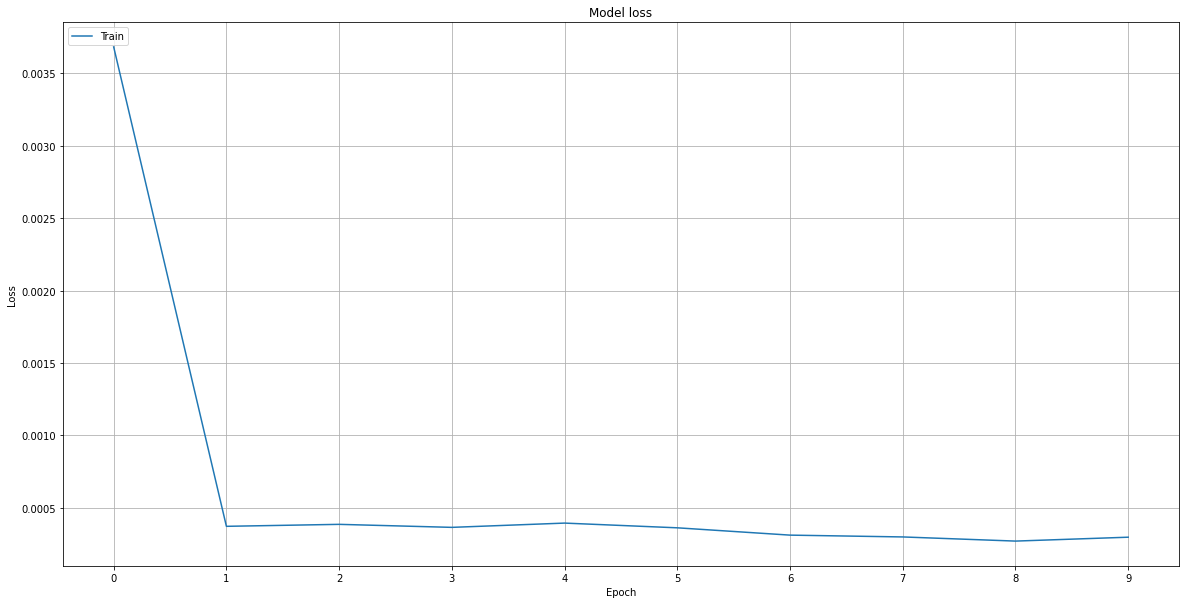

Median Absolute Error (MAE): 1.06
Mean Absolute Percentage Error (MAPE): 2.09 %
Median Absolute Percentage Error (MDAPE): 1.84 %


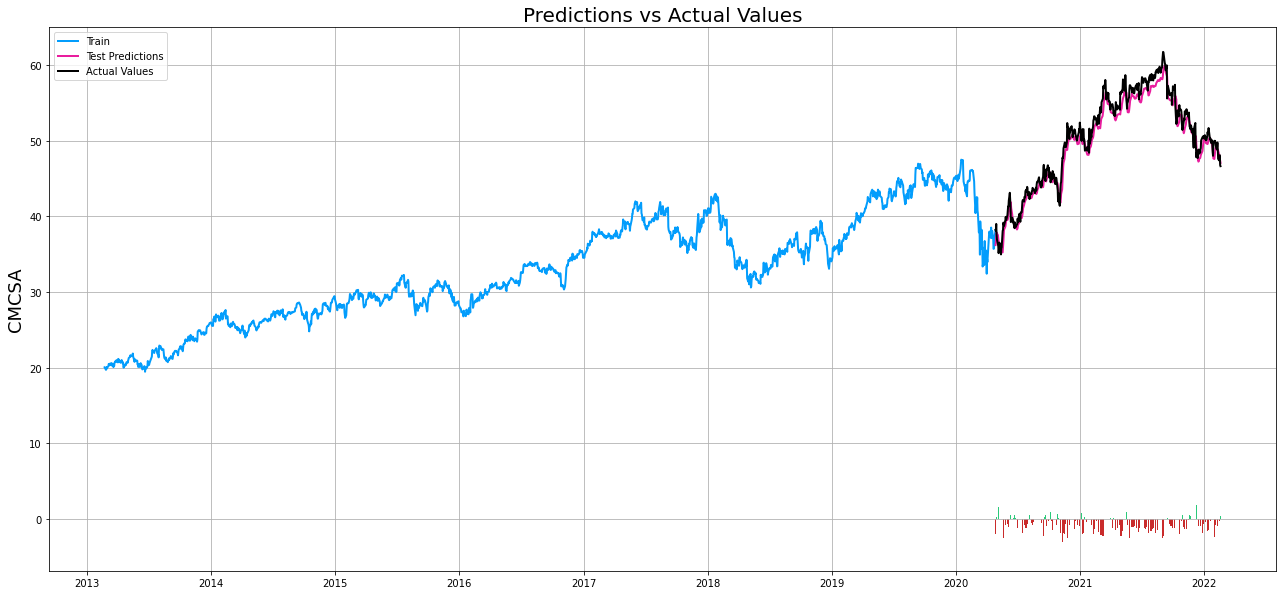

The close price for CMCSA at 2022-02-20 was 46.64
The predicted close price is 46.70000076293945 (+0.13%)
[*********************100%***********************]  1 of 1 completed


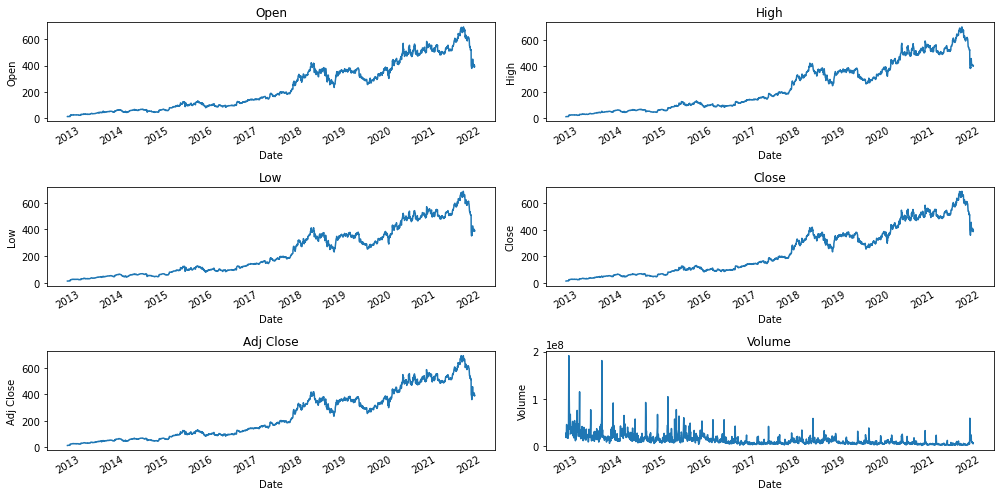

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.01954600281917493
0.01954600281917493
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 300ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 2/10
112/112 [==============================] - 33s 292ms/step - loss: 2.2908e-04 - val_loss: 0.0016
Epoch 3/10
112/112 [==============================] - 33s 290ms/step - loss: 2.8416e-04 - val_loss: 0.0017
Epoch 4/10
112/112 [==============================] - 33s 292ms/step - loss: 2.3468e-04 - val_loss: 0.0019
Epoch 5/10
112/112 [==============================] - 33s 292ms/step - loss: 2.1931e-04 - val_loss: 0.0015
Epoch 6/10
112/112 [==============================] - 33s 291ms/step - loss: 2.1223e-04 - val_loss: 0.0013
Epoch 7/10
112/112 [==============================] - 33s 292ms/step - loss: 2.0683e-04 - val_loss: 0.0011
Epoch 8/10
112/112 [==============================] - 33s 293ms/step - loss: 1.9642e-04 - val_loss

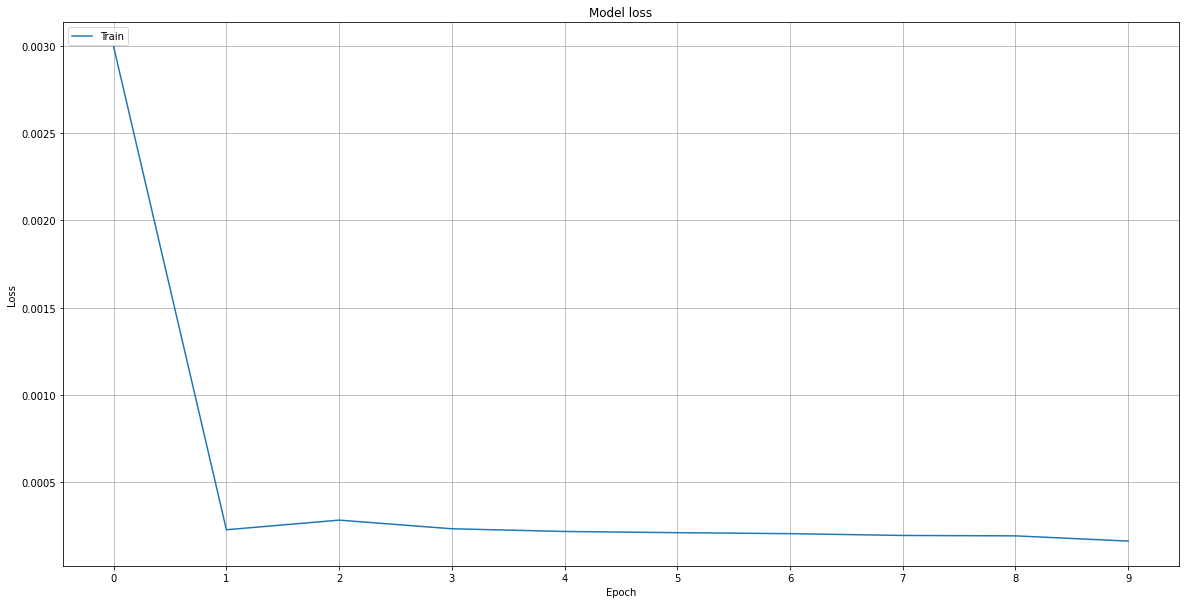

Median Absolute Error (MAE): 15.01
Mean Absolute Percentage Error (MAPE): 2.98 %
Median Absolute Percentage Error (MDAPE): 2.25 %


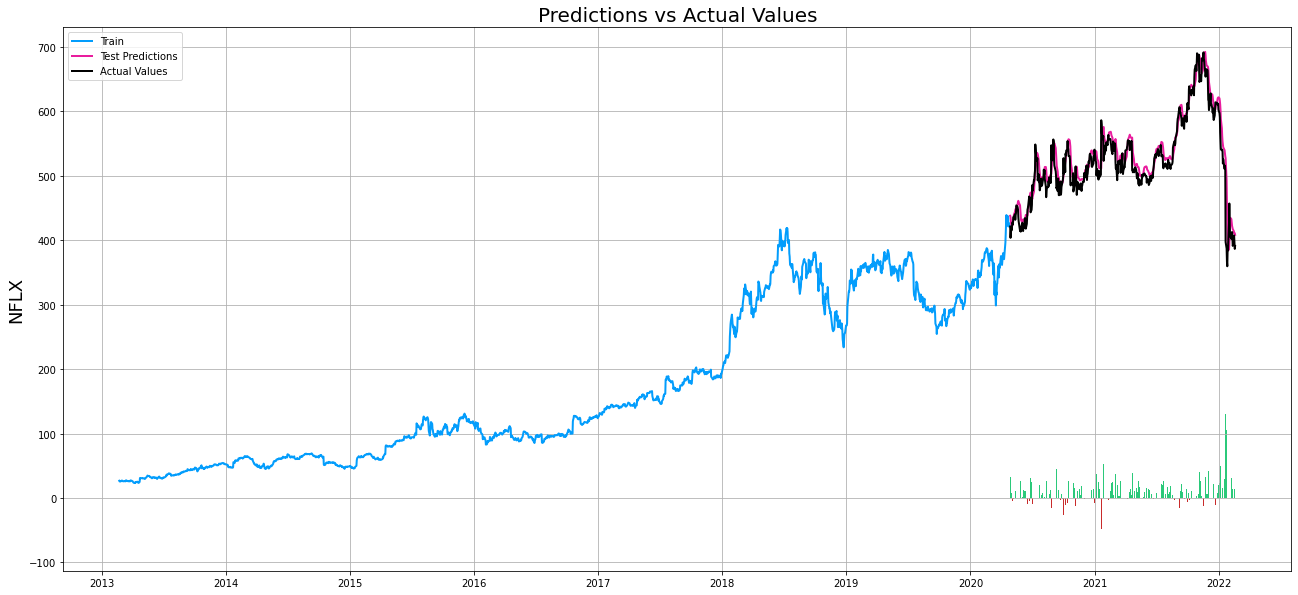

The close price for NFLX at 2022-02-20 was 391.29
The predicted close price is 406.75 (+3.8%)
[*********************100%***********************]  1 of 1 completed


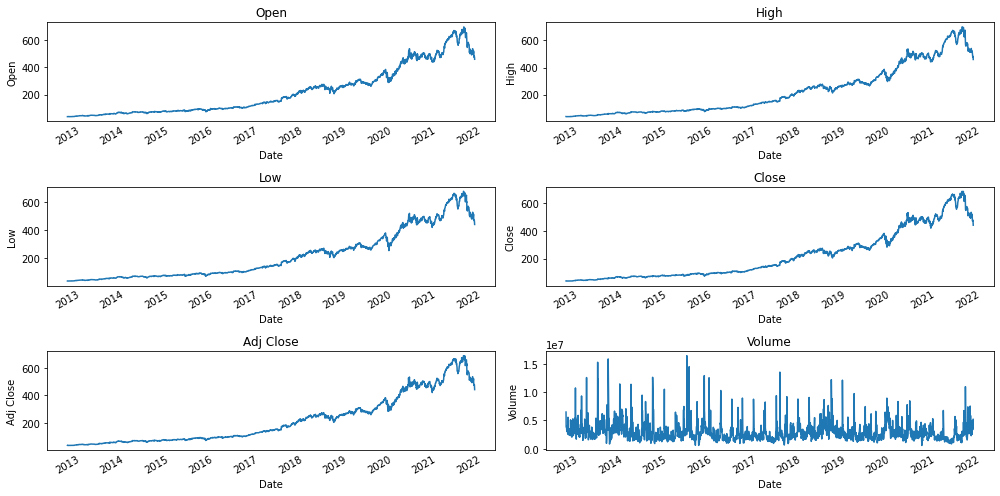

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.0056098634432294806
0.0056098634432294806
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 301ms/step - loss: 0.0011 - val_loss: 8.7262e-04
Epoch 2/10
112/112 [==============================] - 33s 292ms/step - loss: 8.2478e-05 - val_loss: 0.0032
Epoch 3/10
112/112 [==============================] - 33s 292ms/step - loss: 1.2074e-04 - val_loss: 0.0015
Epoch 4/10
112/112 [==============================] - 33s 294ms/step - loss: 1.2849e-04 - val_loss: 7.5660e-04
Epoch 5/10
112/112 [==============================] - 33s 290ms/step - loss: 9.5923e-05 - val_loss: 6.3694e-04
Epoch 6/10
112/112 [==============================] - 33s 294ms/step - loss: 7.6754e-05 - val_loss: 6.1491e-04
Epoch 7/10
112/112 [==============================] - 33s 294ms/step - loss: 7.2367e-05 - val_loss: 0.0018
Epoch 8/10
112/112 [==============================] - 33s 296ms/step - loss: 7

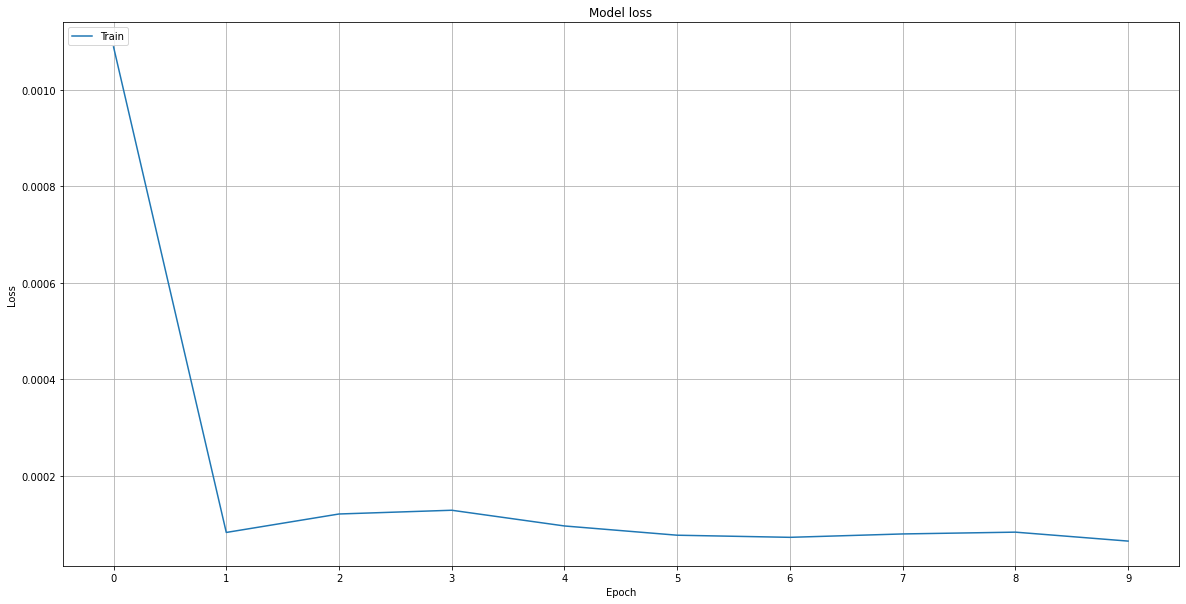

Median Absolute Error (MAE): 12.46
Mean Absolute Percentage Error (MAPE): 2.47 %
Median Absolute Percentage Error (MDAPE): 1.84 %


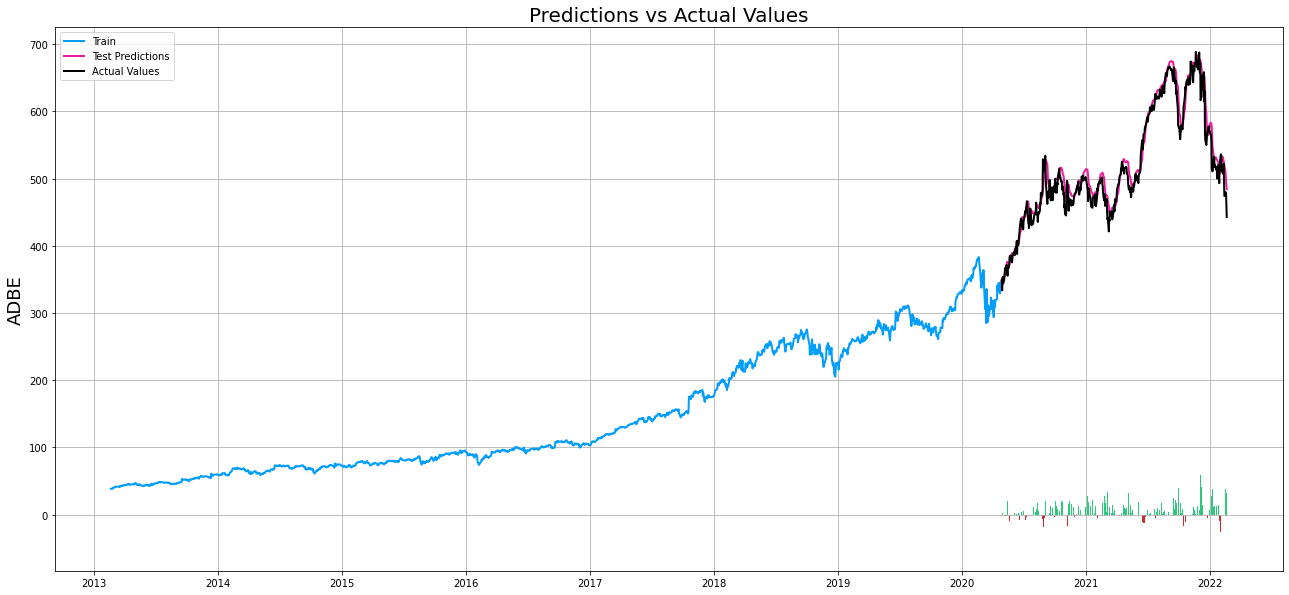

The close price for ADBE at 2022-02-20 was 442.56
The predicted close price is 475.0899963378906 (+6.85%)
[*********************100%***********************]  1 of 1 completed


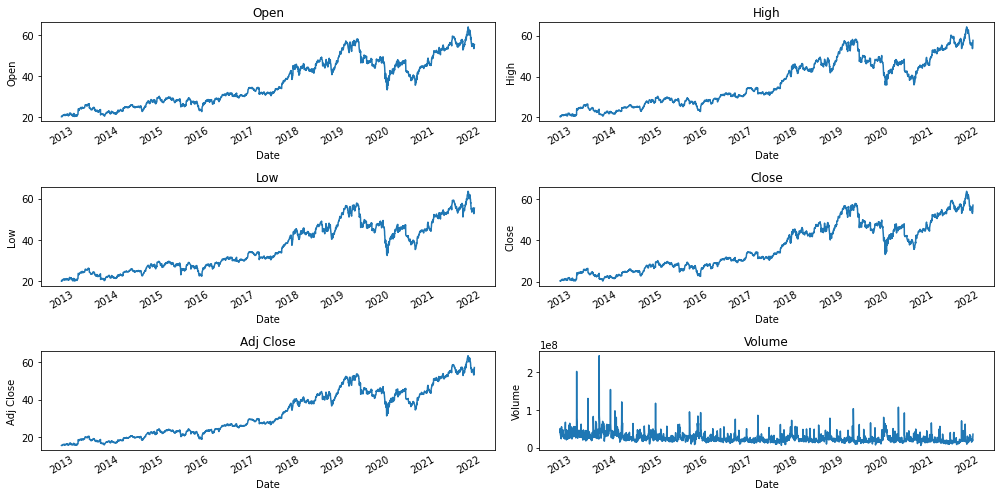

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.03865509059011801
0.03865509059011801
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 307ms/step - loss: 0.0050 - val_loss: 9.9250e-04
Epoch 2/10
112/112 [==============================] - 33s 299ms/step - loss: 5.5196e-04 - val_loss: 9.6745e-04
Epoch 3/10
112/112 [==============================] - 33s 298ms/step - loss: 5.6339e-04 - val_loss: 0.0013
Epoch 4/10
112/112 [==============================] - 33s 295ms/step - loss: 5.1707e-04 - val_loss: 7.2132e-04
Epoch 5/10
112/112 [==============================] - 33s 298ms/step - loss: 4.7179e-04 - val_loss: 9.8775e-04
Epoch 6/10
112/112 [==============================] - 33s 296ms/step - loss: 4.1969e-04 - val_loss: 5.8656e-04
Epoch 7/10
112/112 [==============================] - 33s 298ms/step - loss: 4.1822e-04 - val_loss: 7.4101e-04
Epoch 8/10
112/112 [==============================] - 34s 300ms/step - los

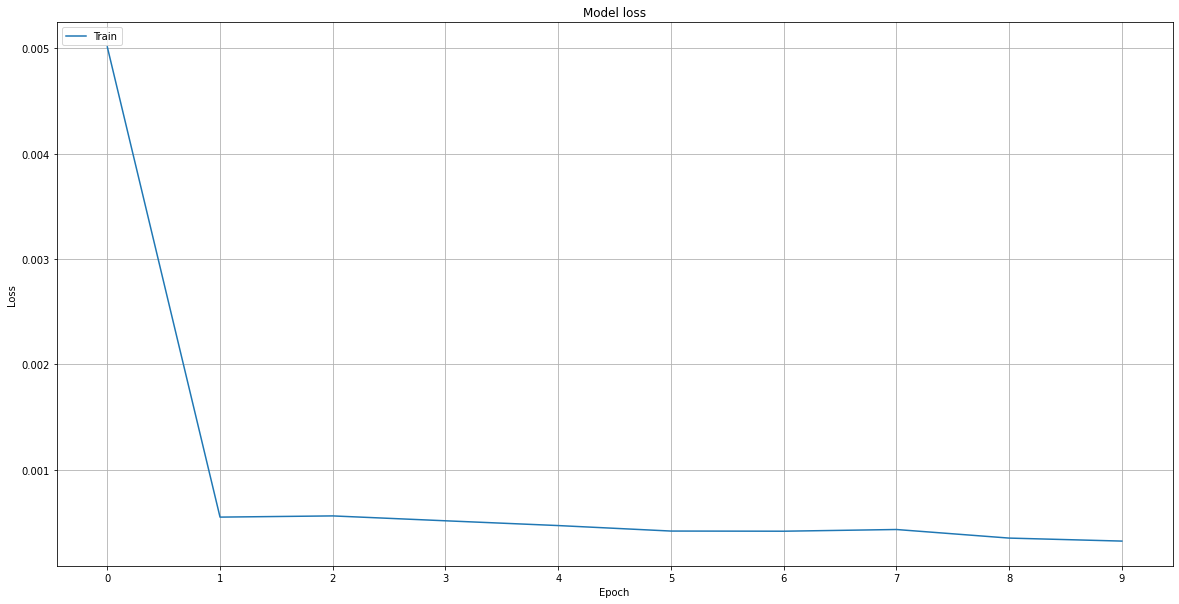

Median Absolute Error (MAE): 0.95
Mean Absolute Percentage Error (MAPE): 1.89 %
Median Absolute Percentage Error (MDAPE): 1.62 %


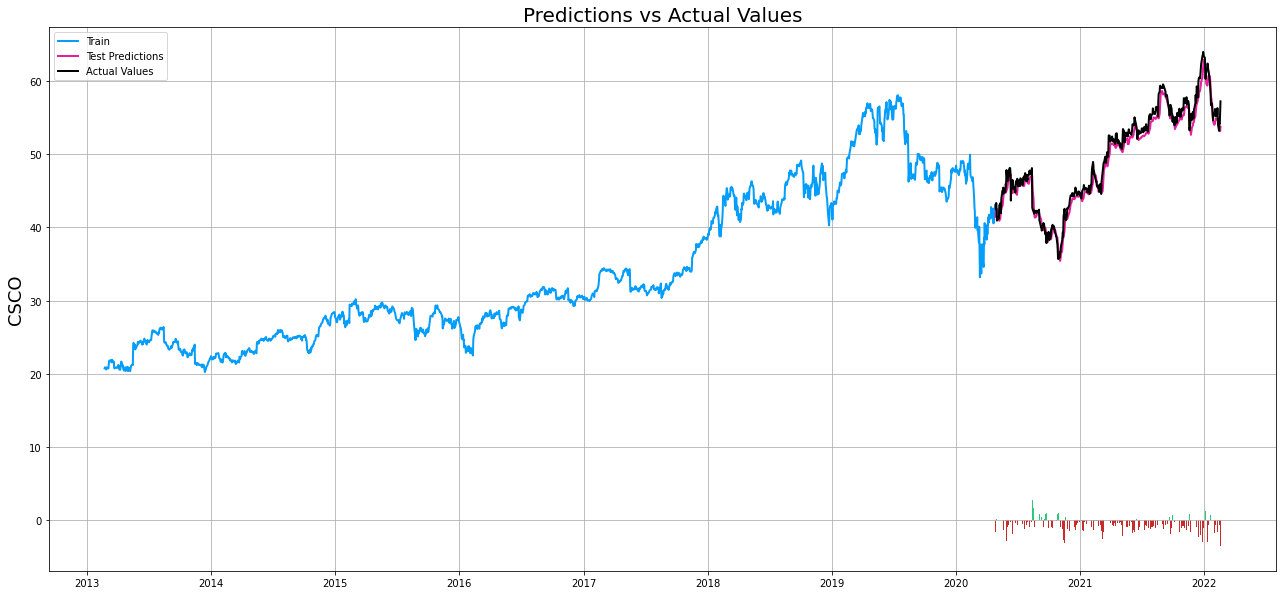

The close price for CSCO at 2022-02-20 was 57.21
The predicted close price is 54.5099983215332 (-4.95%)
[*********************100%***********************]  1 of 1 completed


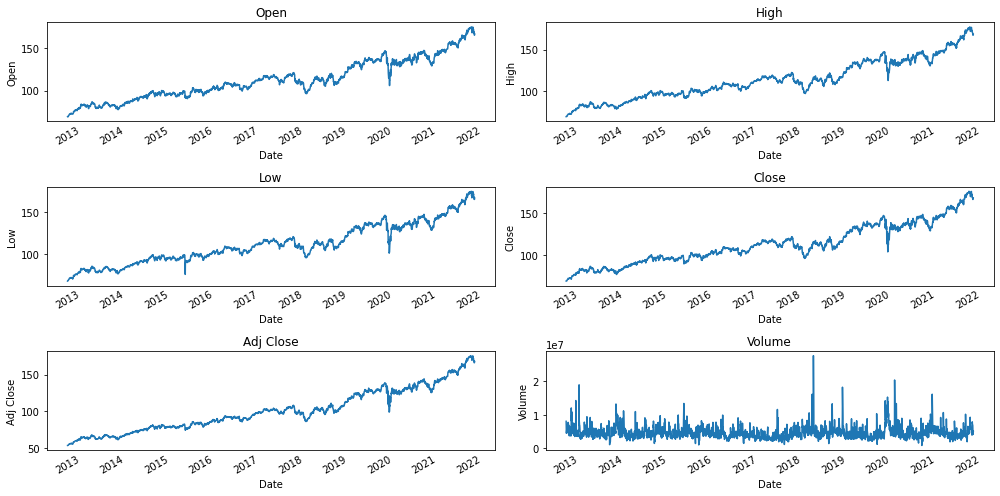

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.07252374434702835
0.07252374434702835
250 50 5
Epoch 1/10
112/112 [==============================] - 39s 307ms/step - loss: 0.0022 - val_loss: 7.4736e-04
Epoch 2/10
112/112 [==============================] - 33s 296ms/step - loss: 4.6322e-04 - val_loss: 0.0012
Epoch 3/10
112/112 [==============================] - 33s 296ms/step - loss: 3.5546e-04 - val_loss: 4.3032e-04
Epoch 4/10
112/112 [==============================] - 34s 302ms/step - loss: 4.4914e-04 - val_loss: 4.1740e-04
Epoch 5/10
112/112 [==============================] - 33s 297ms/step - loss: 3.1471e-04 - val_loss: 0.0012
Epoch 6/10
112/112 [==============================] - 33s 297ms/step - loss: 3.0554e-04 - val_loss: 3.3151e-04
Epoch 7/10
112/112 [==============================] - 33s 297ms/step - loss: 2.8923e-04 - val_loss: 3.6070e-04
Epoch 8/10
112/112 [==============================] - 33s 297ms/step - loss: 3

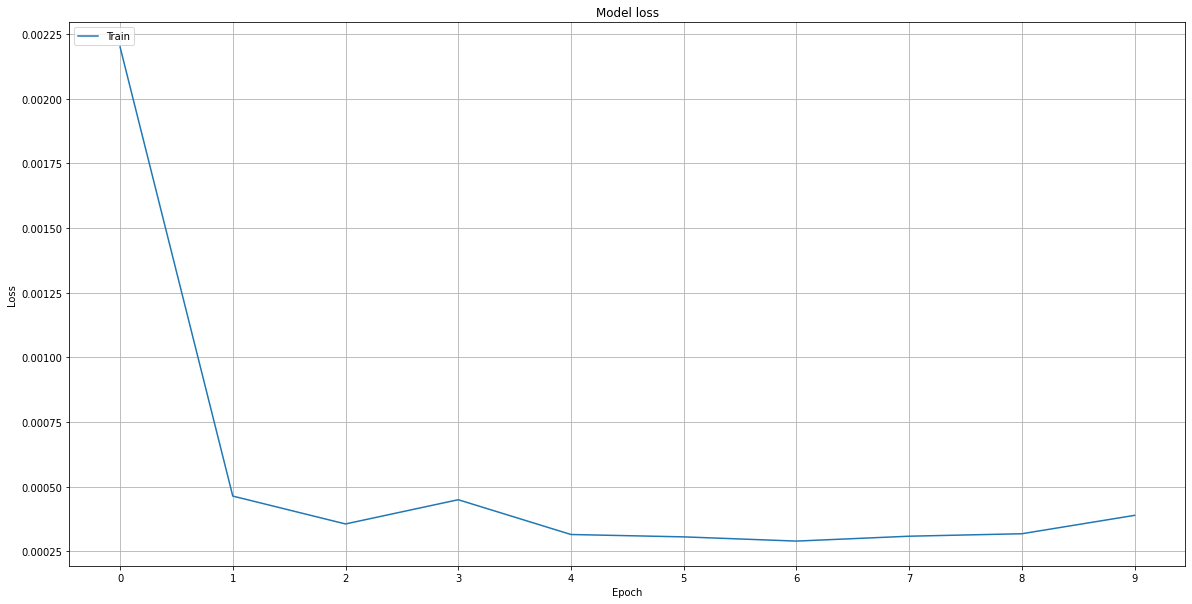

Median Absolute Error (MAE): 1.38
Mean Absolute Percentage Error (MAPE): 0.95 %
Median Absolute Percentage Error (MDAPE): 0.73 %


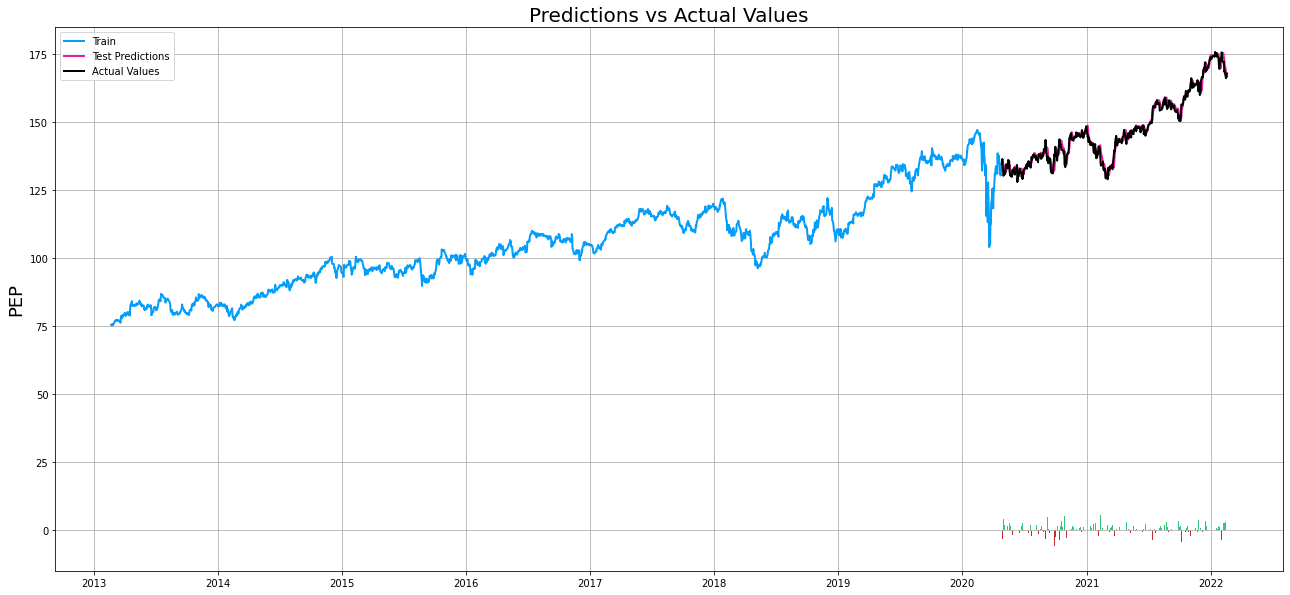

The close price for PEP at 2022-02-20 was 167.71
The predicted close price is 167.10000610351562 (-0.37%)
[*********************100%***********************]  1 of 1 completed


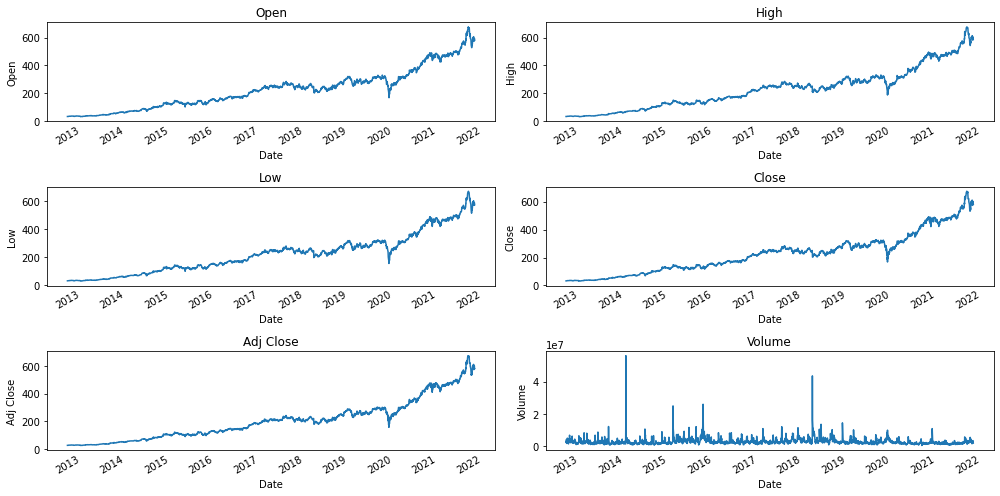

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.007371465206128053
0.007371465206128053
250 50 5
Epoch 1/10
112/112 [==============================] - 39s 307ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 2/10
112/112 [==============================] - 33s 298ms/step - loss: 1.4868e-04 - val_loss: 0.0011
Epoch 3/10
112/112 [==============================] - 33s 297ms/step - loss: 1.5654e-04 - val_loss: 0.0022
Epoch 4/10
112/112 [==============================] - 33s 295ms/step - loss: 1.3967e-04 - val_loss: 8.8488e-04
Epoch 5/10
112/112 [==============================] - 33s 295ms/step - loss: 1.2531e-04 - val_loss: 5.2972e-04
Epoch 6/10
112/112 [==============================] - 33s 296ms/step - loss: 1.4487e-04 - val_loss: 5.6041e-04
Epoch 7/10
112/112 [==============================] - 33s 295ms/step - loss: 1.0969e-04 - val_loss: 4.9084e-04
Epoch 8/10
112/112 [==============================] - 33s 295ms/step - loss: 1.0

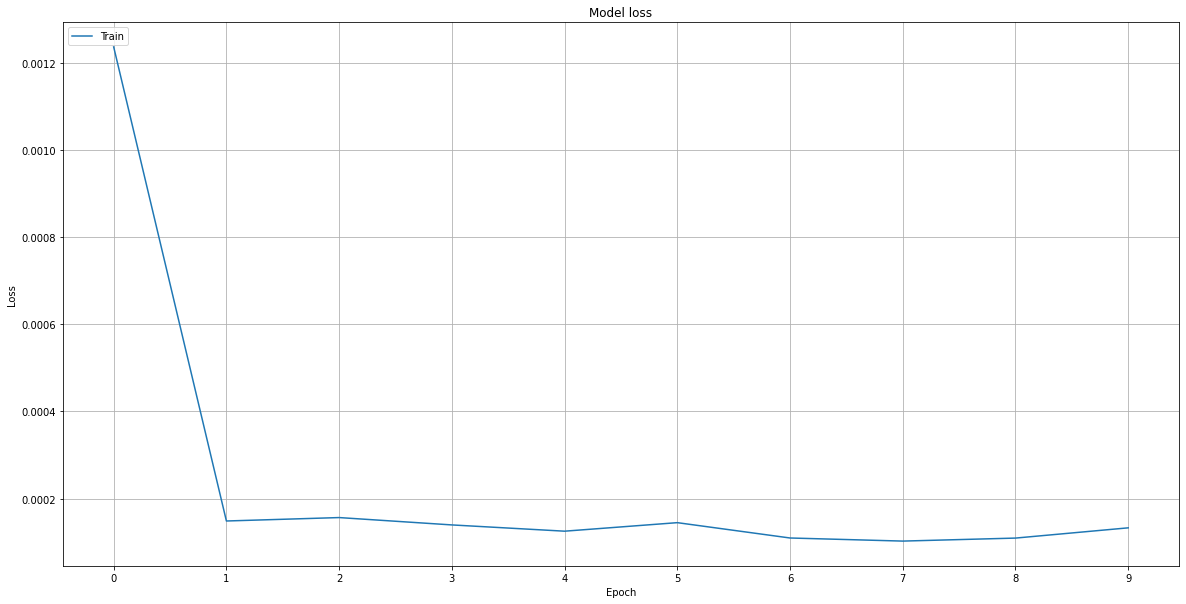

Median Absolute Error (MAE): 12.97
Mean Absolute Percentage Error (MAPE): 2.83 %
Median Absolute Percentage Error (MDAPE): 2.61 %


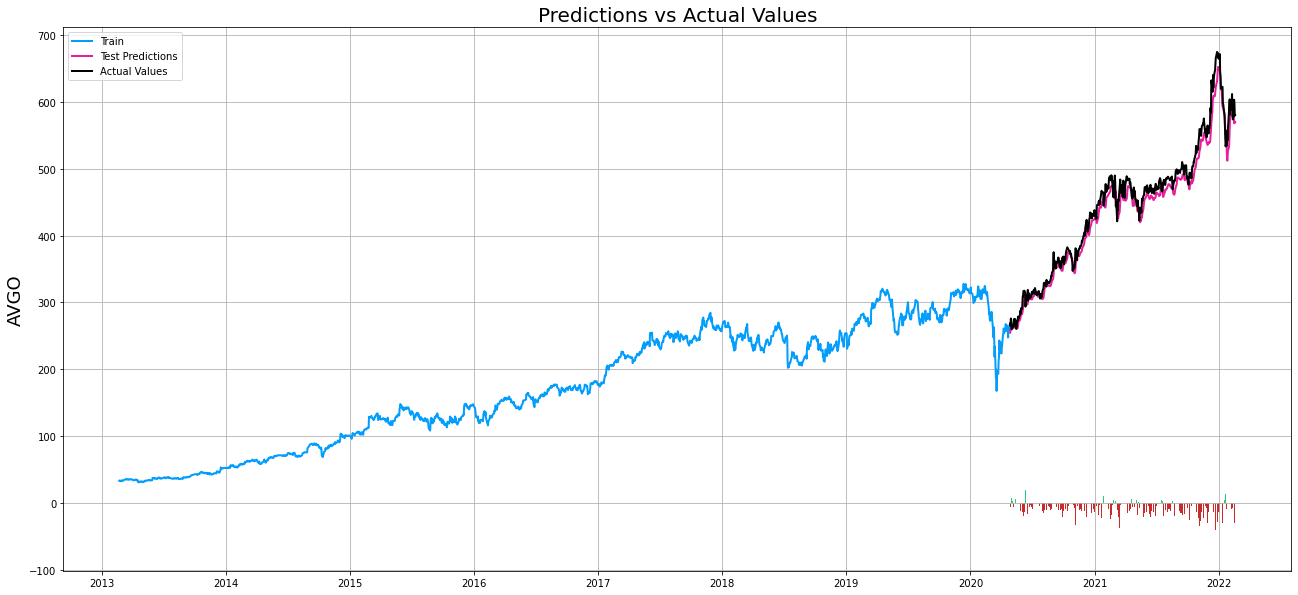

The close price for AVGO at 2022-02-20 was 579.99
The predicted close price is 565.8400268554688 (-2.5%)
[*********************100%***********************]  1 of 1 completed


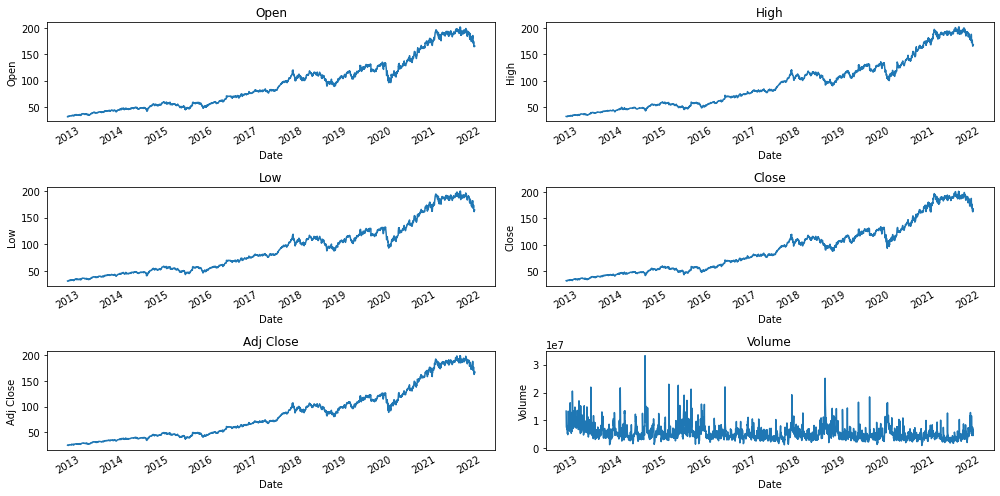

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.020796528324218105
0.020796528324218105
250 50 5
Epoch 1/10
112/112 [==============================] - 38s 308ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/10
112/112 [==============================] - 34s 300ms/step - loss: 2.2142e-04 - val_loss: 5.5620e-04
Epoch 3/10
112/112 [==============================] - 33s 298ms/step - loss: 1.9967e-04 - val_loss: 0.0011
Epoch 4/10
112/112 [==============================] - 33s 296ms/step - loss: 1.8623e-04 - val_loss: 0.0012
Epoch 5/10
112/112 [==============================] - 33s 298ms/step - loss: 2.0093e-04 - val_loss: 5.6605e-04
Epoch 6/10
112/112 [==============================] - 33s 299ms/step - loss: 2.0587e-04 - val_loss: 4.6738e-04
Epoch 7/10
112/112 [==============================] - 33s 299ms/step - loss: 1.6110e-04 - val_loss: 0.0015
Epoch 8/10
112/112 [==============================] - 34s 301ms/step - loss: 1.8433e

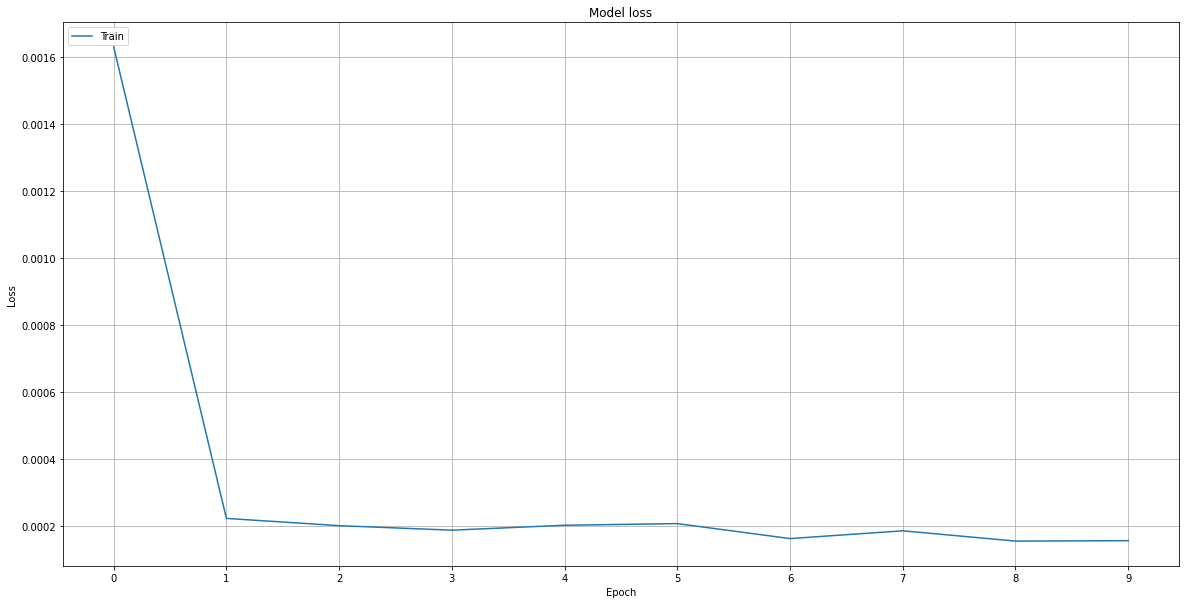

Median Absolute Error (MAE): 3.82
Mean Absolute Percentage Error (MAPE): 2.27 %
Median Absolute Percentage Error (MDAPE): 2.1 %


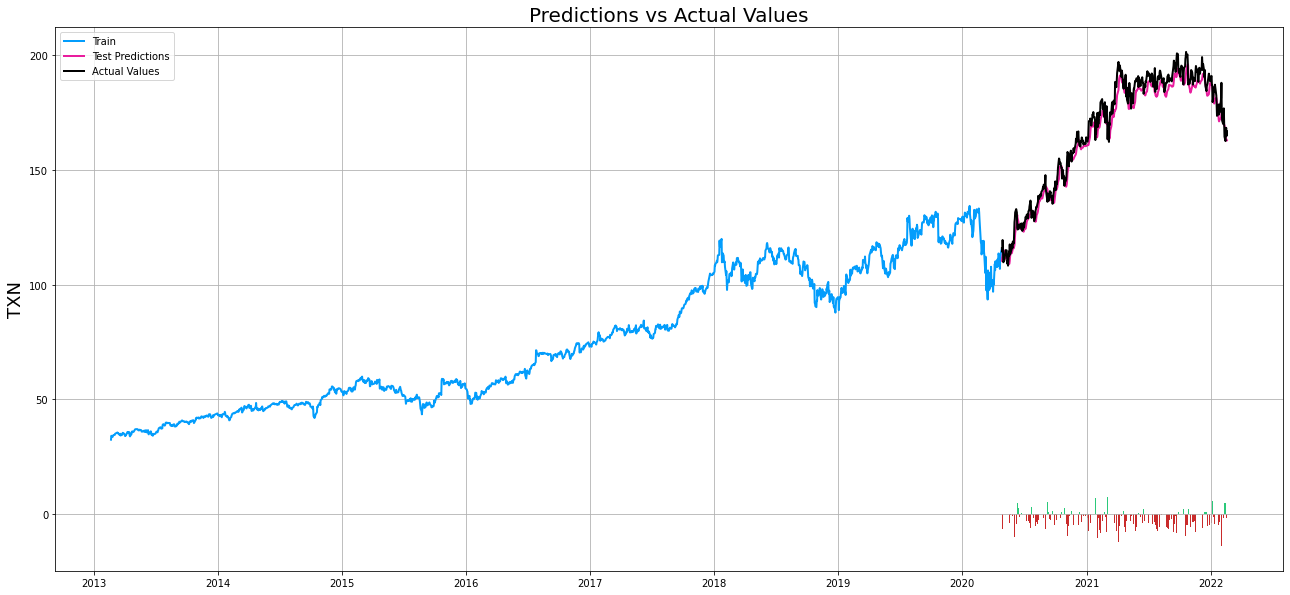

The close price for TXN at 2022-02-20 was 166.74
The predicted close price is 162.8000030517578 (-2.42%)
[*********************100%***********************]  1 of 1 completed


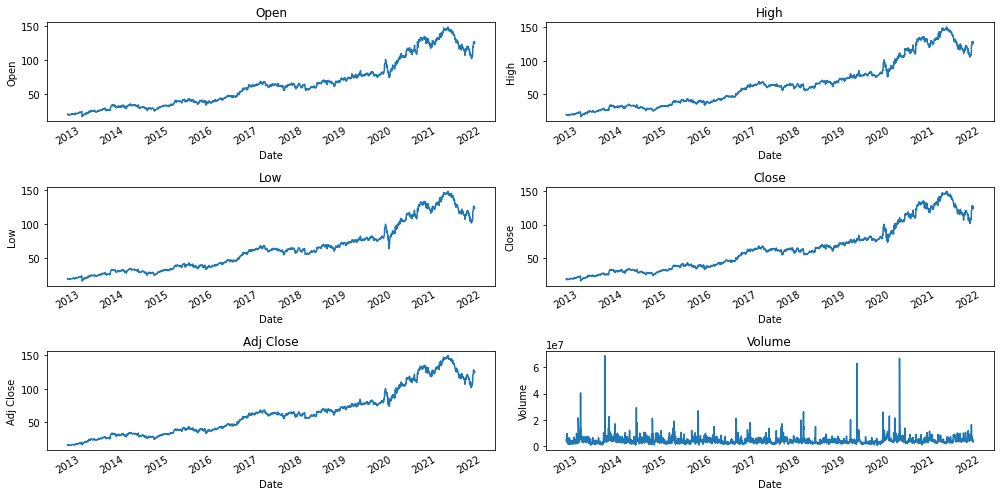

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
(2301, 5)
(1791, 50, 5) (1791,)
(460, 50, 5) (460,)
0.0319060852500567
0.0319060852500567
250 50 5
Epoch 1/10
112/112 [==============================] - 39s 309ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 2/10
112/112 [==============================] - 34s 303ms/step - loss: 1.9551e-04 - val_loss: 0.0015
Epoch 3/10
112/112 [==============================] - 34s 303ms/step - loss: 1.7117e-04 - val_loss: 0.0010
Epoch 4/10
112/112 [==============================] - 34s 299ms/step - loss: 1.6676e-04 - val_loss: 8.7927e-04
Epoch 5/10
112/112 [==============================] - 34s 302ms/step - loss: 1.5791e-04 - val_loss: 0.0017
Epoch 6/10
112/112 [==============================] - 34s 303ms/step - loss: 1.5168e-04 - val_loss: 5.8649e-04
Epoch 7/10
112/112 [==============================] - 34s 304ms/step - loss: 1.5136e-04 - val_loss: 4.6889e-04
Epoch 8/10
112/112 [==============================] - 34s 299ms/step - loss: 1.2497e-04 

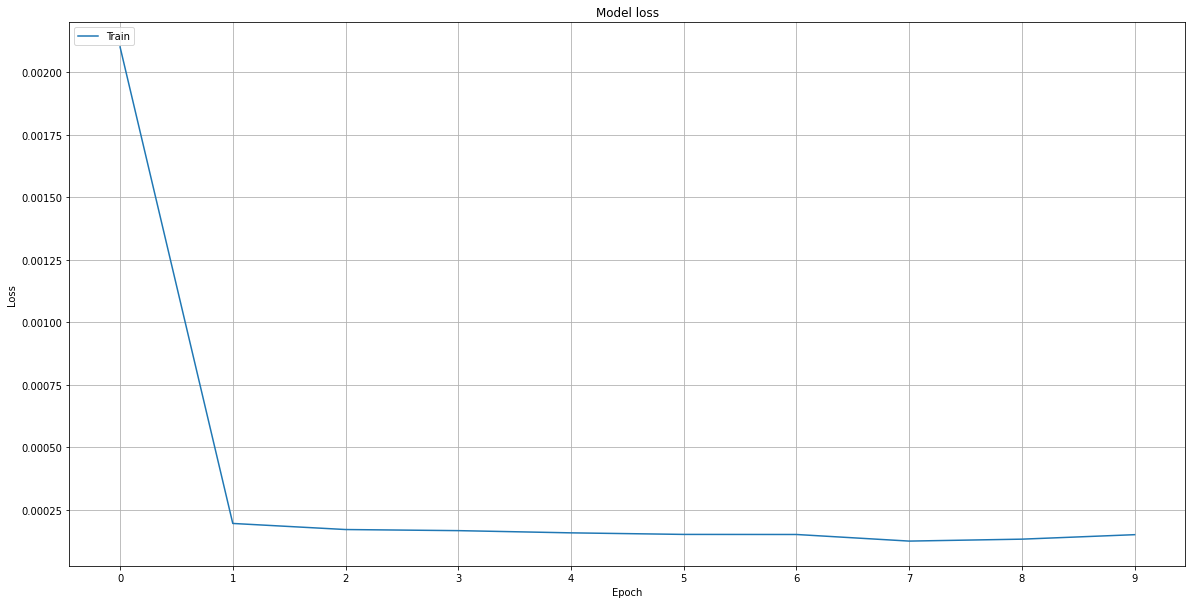

Median Absolute Error (MAE): 2.0
Mean Absolute Percentage Error (MAPE): 1.68 %
Median Absolute Percentage Error (MDAPE): 1.26 %


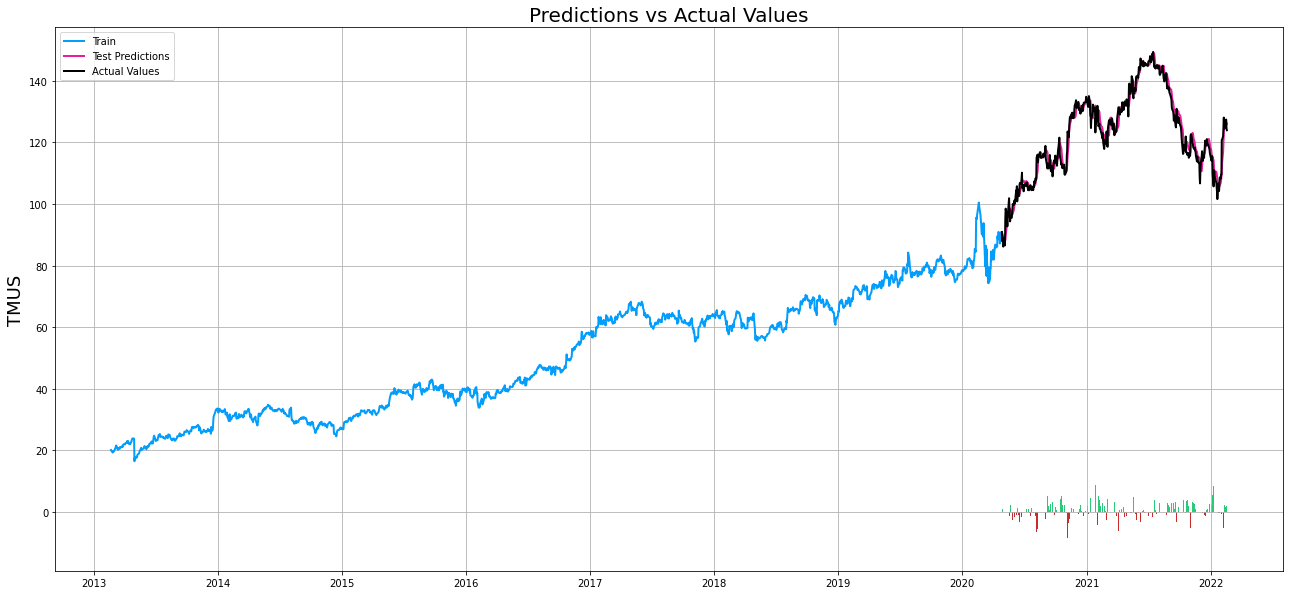

The close price for TMUS at 2022-02-20 was 123.98
The predicted close price is 125.05000305175781 (+0.86%)


In [4]:
model(stock_list,stock_name)